# Northampton Town FC - Analysis of 2017/18 Season

## Introduction

This notebook/script will provide analysis of the soccer dataset files, that i have produced via R, and utilising web scraping techniques. The R scripts, scraped data from the Sporting Life website for Northampton Town FC matches during the 2017/18 League One Football Season.

This script will analyse the following 2 data sources (created by the aforementioned R script) :-

##### A. match_data_v2.csv
This file holds details of all "events" recorded for each game, and scraped from the Sporting Life website. The link below, is an example :-

The file contains the following data items :-
    1. Timing     :-  The minute in the game, that the event occurred.
    2. Event      :-  A text description of the event
    3. event_type :-  The type of event. 
                      For this data item, there are the following list of possible values.
                      
                          GOAL ATTEMPT OPPOSITION         GOAL ATTEMPT COBBLERS
                          SUBSTITUTION OPPOSITION         SUBSTITUTION COBBLERS
                          FOUL OPPOSITION                 FOUL COBBLERS
                          FREE KICK OPPOSITION            FREE KICK COBBLERS
                          CORNER OPPOSITION               CORNER COBBLERS
                          YELLOW CARD OPPOSITION          YELLOW CARD COBBLERS
                          RED CARD OPPOSITION             RED CARD COBBLERS
                          GOAL OPPOSITION                 GOAL COBBLERS
                          INJURY OPPOSITION               INJURY COBBLERS
                          HANDBALL OPPOSITION             HANDBALL COBBLERS
                          PENALTY OPPOSITION              PENALTY COBBLERS
                          
    4. H_A.         :-  Home or Away (for Northampton Town)
    5. added_time   :-  Whether there was any added on time (this will only apply to 45th, and 90th minutes)
    6. match_date   :-  The date of the match
    7. event_player :-  The Cobblers/Northampton Town player, that was involved with the event (if applicable)
    8. match_id     :-  Unique ID number for the match.
    
#### B. match_pos_stats_v1.csv
This file contains possession stats for each match, plus details of the position in the league of each team playing. The file contains the following data items :-
    1. Possession :-  Percentage of possession for the team, during the whole match.
    2. match_id   :-  Unique id for match. Will be the same match_id as found in the above file, match_data_v2.csv.
    3. Team       :-  Name of home, or away team.
    4. League_Position :-  The league position of the team.
    

### Importing Python Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.plotly as py
import plotly.graph_objs as go

### Load up the Source files

In [2]:
# Load the event dataset
m_data = pd.read_csv("match_data_v2.csv")
print("Number of Rows in Event source data file = " + str(m_data.shape[0]))

# Load the Possession / League Position Dataset
p_data = pd.read_csv("match_pos_stats_v1.csv")
print("Number of Rows in Pos/League data file = " + str(p_data.shape[0]))

Number of Rows in Event source data file = 4409
Number of Rows in Pos/League data file = 92


### Describe Source file data
data types, lists head and tail of files

In [3]:
m_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4409 entries, 0 to 4408
Data columns (total 9 columns):
Unnamed: 0      4409 non-null int64
Timing          4363 non-null float64
Event           4409 non-null object
event_type      4409 non-null object
H_A             4409 non-null object
added_time      4409 non-null int64
match_date      4409 non-null object
event_player    4405 non-null object
match_id        4409 non-null int64
dtypes: float64(1), int64(3), object(5)
memory usage: 310.1+ KB


In [4]:
m_data.head()

,Unnamed: 0,Timing,Event,event_type,H_A,added_time,match_date,event_player,match_id
0,1,0.0,"MATCH ENDS, NORTHAMPTON TOWN 2, OLDHAM ATHLETI...",NONE,HOME,0,05-05-2018,NONE,1
1,2,90.0,"SECOND HALF ENDS, NORTHAMPTON TOWN 2, OLDHAM A...",NONE,HOME,8,05-05-2018,NONE,1
2,3,90.0,"SUBSTITUTION, NORTHAMPTON TOWN. MORGAN ROBERTS...",SUBSTITUTION COBBLERS,HOME,6,05-05-2018,NONE,1
3,4,90.0,"CORNER, NORTHAMPTON TOWN. CONCEDED BY ROB HUNT.",CORNER COBBLERS,HOME,3,05-05-2018,NONE,1
4,5,90.0,ATTEMPT SAVED. CRAIG DAVIES (OLDHAM ATHLETIC) ...,GOAL ATTEMPT OPPOSITION,HOME,1,05-05-2018,NONE,1


In [5]:
p_data.head()

,Unnamed: 0,Possession,match_id,Team,League_Position
0,1,55%,1,northampton,22
1,2,45%,1,oldham,20
2,3,46%,2,walsall,20
3,4,54%,2,northampton,22
4,5,49%,3,northampton,22


In [6]:
e_types = m_data['event_type'].value_counts()
e_types

FOUL COBBLERS                            540
GOAL ATTEMPT OPPOSITION                  538
FOUL OPPOSITION                          504
FREE KICK COBBLERS                       501
GOAL ATTEMPT COBBLERS                    379
NONE                                     322
CORNER OPPOSITION                        277
CORNER COBBLERS                          205
FREE KICK OPPOSITION - DEFENSIVE HALF    184
FREE KICK OPPOSITION - ATTACKING HALF    174
SUBSTITUTION COBBLERS                    127
SUBSTITUTION OPPOSITION                  119
YELLOW CARD COBBLERS                      92
FREE KICK OPPOSITION - RIGHT WING         89
FREE KICK OPPOSITION - LEFT WING          89
GOAL OPPOSITION                           77
YELLOW CARD OPPOSITION                    60
GOAL COBBLERS                             42
INJURY COBBLERS                           31
INJURY OPPOSITION                         24
HANDBALL COBBLERS                         10
HANDBALL OPPOSITION                        8
PENALTY OP

In [7]:
m_data.isnull().sum()

Unnamed: 0       0
Timing          46
Event            0
event_type       0
H_A              0
added_time       0
match_date       0
event_player     4
match_id         0
dtype: int64

### Tidying up data
- removal of unnamed first column in each dataset/frame
- remove rows where event_type = 'NONE'
- null values checks
- conversion of timing field to an integer, match_date to a datetime field
- creation of new data field in match data file, Min_Range (15 minute time periods of match, eg. 1st to 15th minute)

In [8]:
# removing the unwanted unnamed column
m_data = m_data[['Timing','Event','event_type','H_A','added_time','match_date','event_player','match_id']]
# remove any rows where event_type = NONE
m_data = m_data[(m_data['event_type']!="NONE")]
# remove whitespace on event_player column
m_data['event_player'].str.strip()
m_data.head()

,Timing,Event,event_type,H_A,added_time,match_date,event_player,match_id
2,90.0,"SUBSTITUTION, NORTHAMPTON TOWN. MORGAN ROBERTS...",SUBSTITUTION COBBLERS,HOME,6,05-05-2018,NONE,1
3,90.0,"CORNER, NORTHAMPTON TOWN. CONCEDED BY ROB HUNT.",CORNER COBBLERS,HOME,3,05-05-2018,NONE,1
4,90.0,ATTEMPT SAVED. CRAIG DAVIES (OLDHAM ATHLETIC) ...,GOAL ATTEMPT OPPOSITION,HOME,1,05-05-2018,NONE,1
5,90.0,ATTEMPT BLOCKED. CRAIG DAVIES (OLDHAM ATHLETIC...,GOAL ATTEMPT OPPOSITION,HOME,1,05-05-2018,NONE,1
6,87.0,MATT GRIMES (NORTHAMPTON TOWN) WINS A FREE KIC...,FREE KICK COBBLERS,HOME,0,05-05-2018,MATT GRIMES,1


In [9]:
# removing the unwanted unnamed column
p_data = p_data[['Possession','match_id','Team','League_Position']]
p_data.head()

,Possession,match_id,Team,League_Position
0,55%,1,northampton,22
1,45%,1,oldham,20
2,46%,2,walsall,20
3,54%,2,northampton,22
4,49%,3,northampton,22


In [10]:
m_data['Timing'] = m_data['Timing'].astype(int)
m_data['match_date']= pd.to_datetime(m_data['match_date'], format='%d-%m-%Y')
m_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4087 entries, 2 to 4406
Data columns (total 8 columns):
Timing          4087 non-null int64
Event           4087 non-null object
event_type      4087 non-null object
H_A             4087 non-null object
added_time      4087 non-null int64
match_date      4087 non-null datetime64[ns]
event_player    4083 non-null object
match_id        4087 non-null int64
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 287.4+ KB


In [11]:
# creation of new data item, Min_Range, which groups timings of events into 15 minute intervals
m_data['Min_Range']=''
r1=range(1,16)
r2=range(16,31)
r3=range(31,46)
r4=range(46,61)
r5=range(61,76)
r6=range(76,91)
for rows in range(0,m_data.shape[0]):
    # print(m_data.iloc[rows,1])
    if (m_data.iloc[rows,0] in r1):
        # print("range 1")
        m_data.iloc[rows,8]="1-15 mins"
    if (m_data.iloc[rows,0] in r2):
        # print("range 2")
        m_data.iloc[rows,8]="16-30 mins"
    if (m_data.iloc[rows,0] in r3):
        # print("range 3")
        m_data.iloc[rows,8]="31-45 mins"
        if ((m_data.iloc[rows,4]>0) & (m_data.iloc[rows,0]==45)):
            # print("found 45th min, added time")
            m_data.iloc[rows,0] = 45.5
            m_data.iloc[rows,8] = "45+"
    if (m_data.iloc[rows,0] in r4):
        # print("range 4")
        m_data.iloc[rows,8]="46-60 mins"
    if (m_data.iloc[rows,0] in r5):
        # print("range 5")
        m_data.iloc[rows,8]="61-75 mins"
    if (m_data.iloc[rows,0] in r6):
        # print("range 6")
        m_data.iloc[rows,8]="76-90 mins" 
        # check if added time and 90th min, if so, then recalc Timing = Timing + Added_Time
        if ((m_data.iloc[rows,4]>0) & (m_data.iloc[rows,0]==90)):
            # print("found 90th min, added time")
            m_data.iloc[rows,0]=91
            m_data.iloc[rows,8]="90+"

In [12]:
print("Number of Rows in source data (with NONE removed) = " + str(m_data.shape[0]))
print("Null value counts for each Column in dataframe")
m_data.isnull().sum()

Number of Rows in source data (with NONE removed) = 4087
Null value counts for each Column in dataframe


Timing          0
Event           0
event_type      0
H_A             0
added_time      0
match_date      0
event_player    4
match_id        0
Min_Range       0
dtype: int64

In [13]:
m_data.head()

,Timing,Event,event_type,H_A,added_time,match_date,event_player,match_id,Min_Range
2,91.0,"SUBSTITUTION, NORTHAMPTON TOWN. MORGAN ROBERTS...",SUBSTITUTION COBBLERS,HOME,6,2018-05-05,NONE,1,90+
3,91.0,"CORNER, NORTHAMPTON TOWN. CONCEDED BY ROB HUNT.",CORNER COBBLERS,HOME,3,2018-05-05,NONE,1,90+
4,91.0,ATTEMPT SAVED. CRAIG DAVIES (OLDHAM ATHLETIC) ...,GOAL ATTEMPT OPPOSITION,HOME,1,2018-05-05,NONE,1,90+
5,91.0,ATTEMPT BLOCKED. CRAIG DAVIES (OLDHAM ATHLETIC...,GOAL ATTEMPT OPPOSITION,HOME,1,2018-05-05,NONE,1,90+
6,87.0,MATT GRIMES (NORTHAMPTON TOWN) WINS A FREE KIC...,FREE KICK COBBLERS,HOME,0,2018-05-05,MATT GRIMES,1,76-90 mins


### Analysis / Visualisation of Data

In [14]:
sns.set(style="darkgrid", palette="Paired")

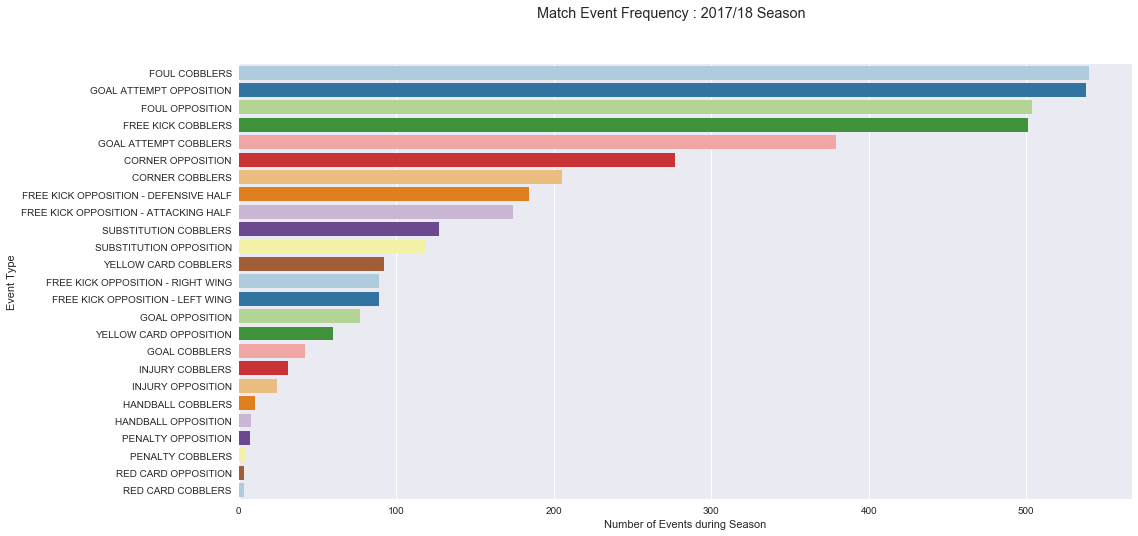

In [15]:
from matplotlib.pyplot import suptitle
plt.figure(figsize=(16,8))
evtplt = sns.countplot(y='event_type', data=m_data, palette="Paired",
                      order = m_data['event_type'].value_counts().sort_values(ascending=False).index)
evtplt.set_xlabel("Number of Events during Season")
evtplt.set_ylabel("Event Type")
suptitle("Match Event Frequency : 2017/18 Season")
plt.show()

### Analysis of Event Types per Match

In [16]:
# m_data.groupby(['match_id','event_type']).count()
mstats = m_data.pivot_table(index=('match_date','match_id'),columns='event_type',aggfunc=len, fill_value=0)
mstats.columns = mstats.columns.droplevel()
mstats.columns.name = None
mstats.reset_index(inplace=True)
mstats.sort_values(by='match_date',ascending=0)
mstats.head()

,match_date,match_id,CORNER COBBLERS,CORNER OPPOSITION,FOUL COBBLERS,FOUL OPPOSITION,FREE KICK COBBLERS,FREE KICK OPPOSITION - ATTACKING HALF,FREE KICK OPPOSITION - DEFENSIVE HALF,FREE KICK OPPOSITION - LEFT WING,...,INJURY COBBLERS,INJURY OPPOSITION,PENALTY COBBLERS,PENALTY OPPOSITION,RED CARD COBBLERS,RED CARD OPPOSITION,SUBSTITUTION COBBLERS,SUBSTITUTION OPPOSITION,YELLOW CARD COBBLERS,YELLOW CARD OPPOSITION
0,2017-08-05,46,4,7,17,16,16,4,7,5,...,1,0,0,0,0,0,3,2,1,2
1,2017-08-12,45,6,4,8,9,9,3,3,2,...,0,0,0,0,0,0,3,3,0,2
2,2017-08-19,44,2,6,7,8,8,2,3,2,...,1,1,0,0,0,0,3,3,2,2
3,2017-08-26,43,4,2,13,20,20,4,5,2,...,0,2,0,1,0,0,3,3,1,1
4,2017-09-09,42,3,9,12,4,4,7,4,0,...,3,0,0,0,0,0,3,3,0,1


In [17]:
sns.set(style="darkgrid", palette="Paired")

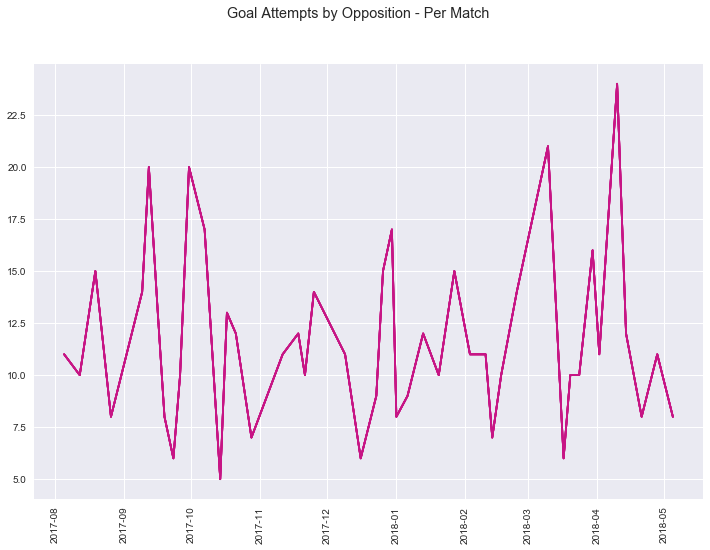

In [18]:
from matplotlib.pyplot import suptitle
plt.figure(figsize=(12,8))
suptitle("Goal Attempts by Opposition - Per Match")
plt.plot( 'match_date', 'GOAL ATTEMPT OPPOSITION', data=mstats, color='mediumvioletred')
# plt.gca().invert_xaxis()
plt.setp(plt.gca().get_xticklabels(), rotation=90)
plt.show()

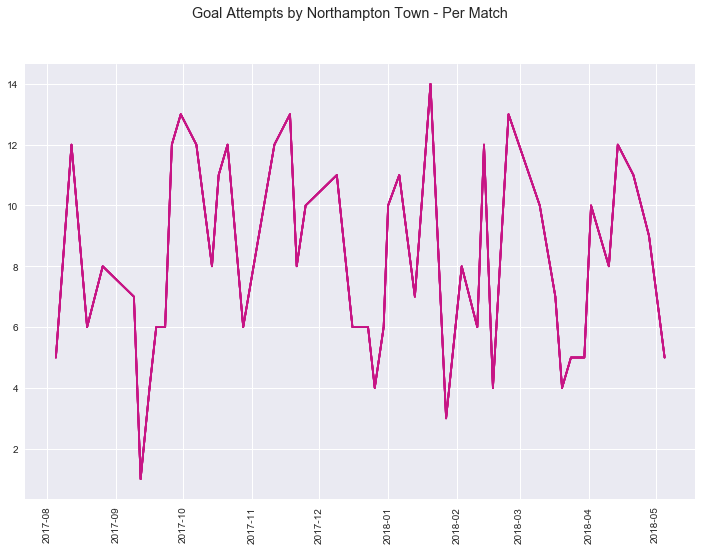

In [19]:
plt.figure(figsize=(12,8))
suptitle("Goal Attempts by Northampton Town - Per Match")
plt.plot( 'match_date', 'GOAL ATTEMPT COBBLERS', data=mstats, color='mediumvioletred')
# plt.gca().invert_xaxis()
plt.setp(plt.gca().get_xticklabels(), rotation=90)
plt.show()

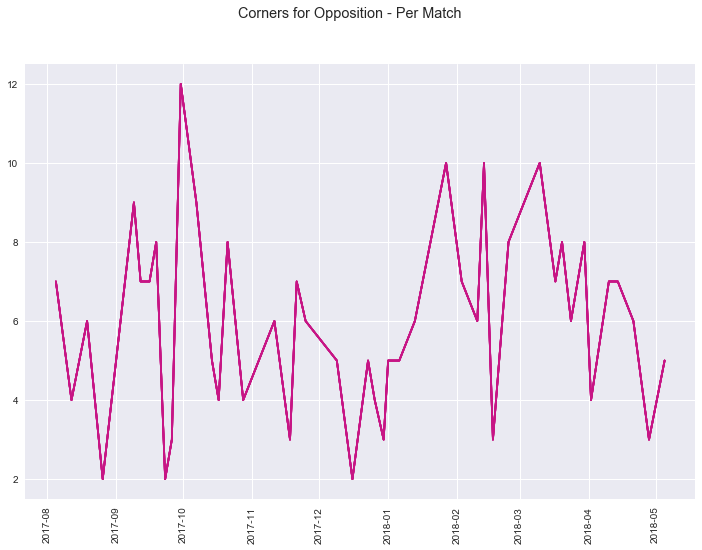

In [20]:
plt.figure(figsize=(12,8))
suptitle("Corners for Opposition - Per Match")
plt.plot( 'match_date', 'CORNER OPPOSITION', data=mstats, color='mediumvioletred')
# plt.gca().invert_xaxis()
plt.setp(plt.gca().get_xticklabels(), rotation=90)
plt.show()

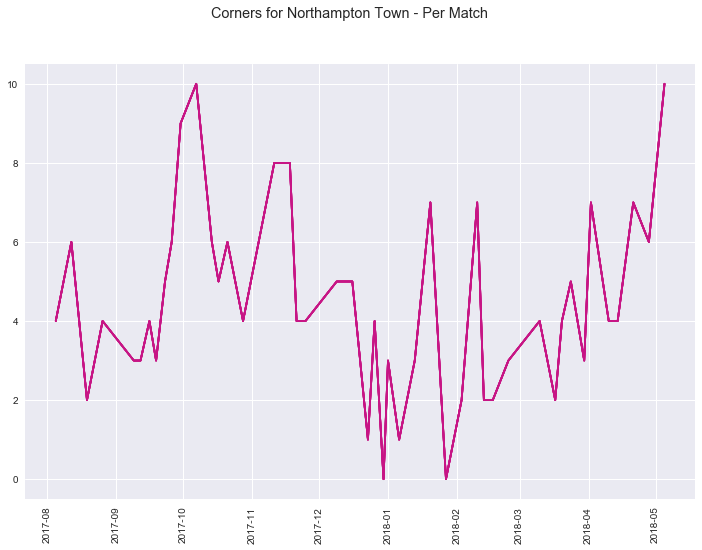

In [21]:
plt.figure(figsize=(12,8))
suptitle("Corners for Northampton Town - Per Match")
plt.plot( 'match_date', 'CORNER COBBLERS', data=mstats, color='mediumvioletred')
# plt.gca().invert_xaxis()
plt.setp(plt.gca().get_xticklabels(), rotation=90)
plt.show()

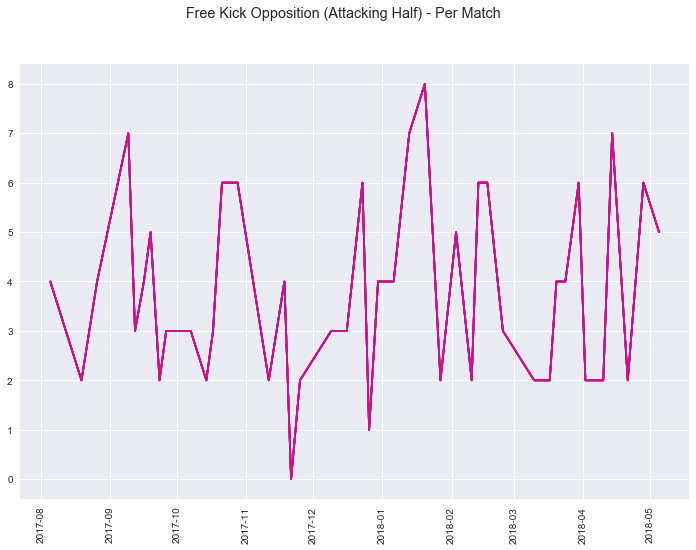

In [22]:
plt.figure(figsize=(12,8))
suptitle("Free Kick Opposition (Attacking Half) - Per Match")
plt.plot( 'match_date', 'FREE KICK OPPOSITION - ATTACKING HALF', data=mstats, color='mediumvioletred')
# plt.gca().invert_xaxis()
plt.setp(plt.gca().get_xticklabels(), rotation=90)
plt.show()

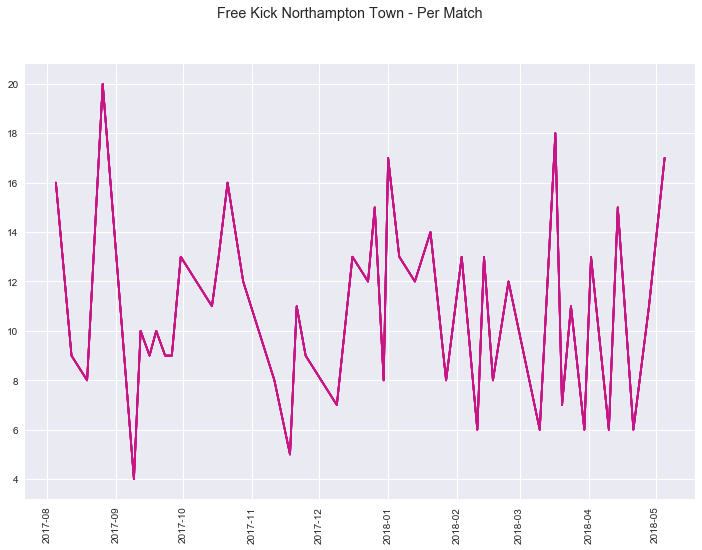

In [23]:
plt.figure(figsize=(12,8))
suptitle("Free Kick Northampton Town - Per Match")
plt.plot( 'match_date', 'FREE KICK COBBLERS', data=mstats, color='mediumvioletred')
# plt.gca().invert_xaxis()
plt.setp(plt.gca().get_xticklabels(), rotation=90)
plt.show()

### Analysis of Event Types by Player

In [24]:
play_data = m_data[(m_data['event_player']!="NONE") & 
                   (m_data['event_player'].str.slice(0,6)!="SECOND")]

In [25]:
# create pivot table to show players and events they were involved with, + frequencies
play_events = pd.DataFrame(play_data[["event_player","event_type","H_A"]])
p_stats_evts = play_events.pivot_table(index=('event_player','H_A'),columns='event_type',aggfunc=len, fill_value=0)
# p_stats_evts.columns = p_stats_evts.columns.droplevel()
# p_stats_evts.columns.name = None
p_stats_evts.reset_index(inplace=True)
p_stats_evts.head()

event_type,event_player,H_A,CORNER OPPOSITION,FOUL COBBLERS,FREE KICK COBBLERS,GOAL ATTEMPT COBBLERS,GOAL COBBLERS,INJURY COBBLERS,RED CARD COBBLERS,YELLOW CARD COBBLERS
0,AARON PHILLIPS,AWAY,0,0,0,0,0,1,0,0
1,AARON PIERRE,AWAY,6,12,5,4,0,0,0,2
2,AARON PIERRE,HOME,8,9,6,6,0,0,0,0
3,ALEX REVELL,AWAY,0,3,7,10,0,1,0,0
4,ALEX REVELL,HOME,0,10,7,6,2,0,1,0


In [26]:
# get all rows for HOME related stats, ie. H_A = HOME
p_stats_evts_home = p_stats_evts[(p_stats_evts['H_A']=="HOME")]
# get all rows for AWAY related stats, ie. H_A = AWAY
p_stats_evts_away = p_stats_evts[(p_stats_evts['H_A']=="AWAY")]

# get the row of max value for GOAL ATTEMPT COBBLERS
p_stats_evts_home.loc[p_stats_evts_home['GOAL ATTEMPT COBBLERS'].idxmax()]
top5_gatt_H = pd.DataFrame(p_stats_evts_home.nlargest(5, 'GOAL ATTEMPT COBBLERS'))

p_stats_evts_away.loc[p_stats_evts_away['GOAL ATTEMPT COBBLERS'].idxmax()]
top5_gatt_A = pd.DataFrame(p_stats_evts_away.nlargest(5, 'GOAL ATTEMPT COBBLERS'))

play_events_all = pd.DataFrame(play_data[["event_player","event_type"]])
p_stats_evts_all = play_events_all.pivot_table(index=('event_player'),columns='event_type',aggfunc=len, fill_value=0)
p_stats_evts_all.reset_index(inplace=True)
p_stats_evts_all.loc[p_stats_evts_all['GOAL ATTEMPT COBBLERS'].idxmax()]
top5_gatt = pd.DataFrame(p_stats_evts_all.nlargest(5, 'GOAL ATTEMPT COBBLERS'))
top5_gatt.head()

event_type,event_player,CORNER OPPOSITION,FOUL COBBLERS,FREE KICK COBBLERS,GOAL ATTEMPT COBBLERS,GOAL COBBLERS,INJURY COBBLERS,RED CARD COBBLERS,YELLOW CARD COBBLERS
7,CHRIS LONG,2,24,37,55,9,1,0,4
25,MATT GRIMES,15,46,59,41,4,1,0,11
32,SAM HOSKINS,7,24,30,33,2,1,0,5
24,MATT CROOKS,9,69,29,31,4,3,0,13
8,DANIEL POWELL,4,35,26,24,2,1,0,3


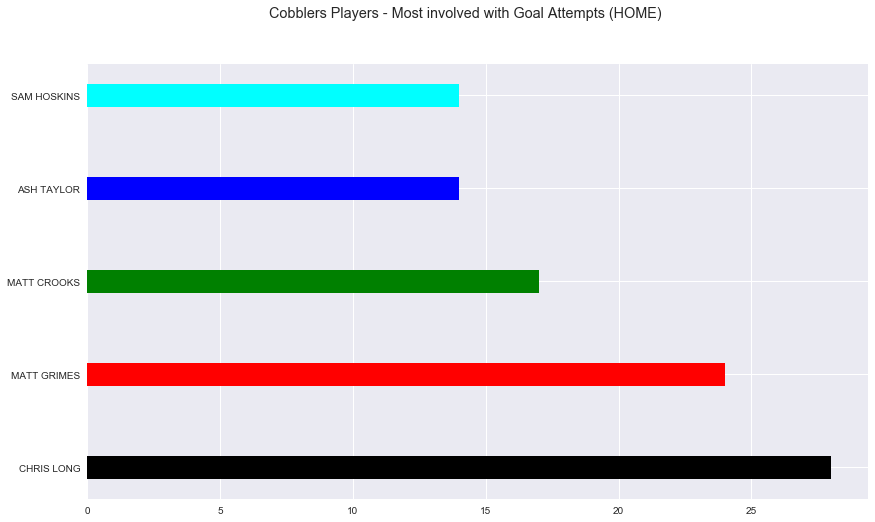

In [27]:
from matplotlib.pyplot import suptitle
plt.figure(figsize=(14,8))
# Create horizontal bars
plt.barh(top5_gatt_H['event_player'], 
         top5_gatt_H['GOAL ATTEMPT COBBLERS'], 
         color=['black', 'red', 'green', 'blue', 'cyan'],
         height=0.25) 
# Create names on the y-axis
plt.yticks(top5_gatt_H['event_player'])
suptitle("Cobblers Players - Most involved with Goal Attempts (HOME)")
# Show graphic
plt.show()

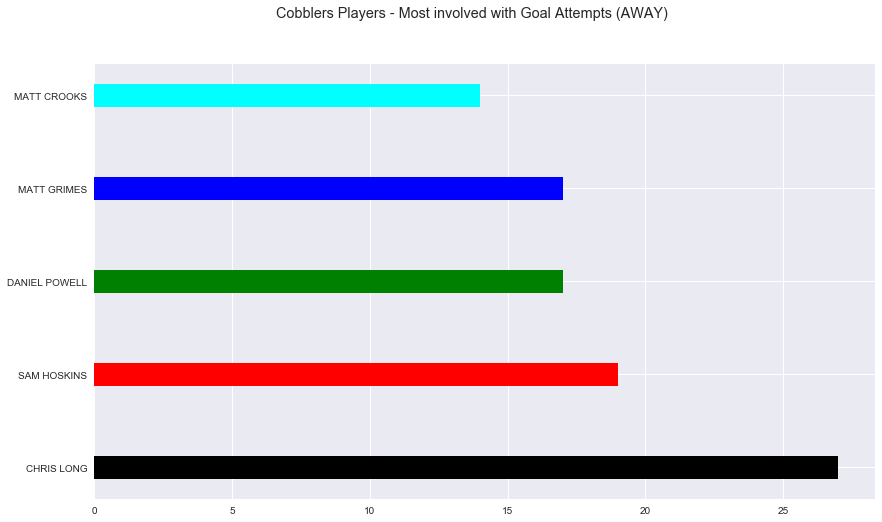

In [28]:
plt.figure(figsize=(14,8))
# Create horizontal bars
plt.barh(top5_gatt_A['event_player'], 
         top5_gatt_A['GOAL ATTEMPT COBBLERS'], 
         color=['black', 'red', 'green', 'blue', 'cyan'],
         height=0.25) 
# Create names on the y-axis
plt.yticks(top5_gatt_A['event_player'])
suptitle("Cobblers Players - Most involved with Goal Attempts (AWAY)")
# Show graphic
plt.show()

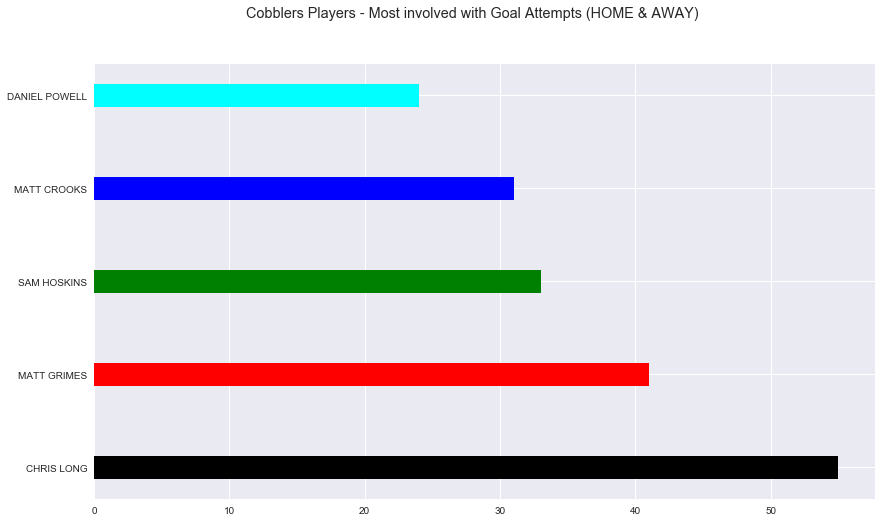

In [29]:
plt.figure(figsize=(14,8))
# Create horizontal bars
plt.barh(top5_gatt['event_player'], 
         top5_gatt['GOAL ATTEMPT COBBLERS'], 
         color=['black', 'red', 'green', 'blue', 'cyan'],
         height=0.25) 
# Create names on the y-axis
plt.yticks(top5_gatt['event_player'])
suptitle("Cobblers Players - Most involved with Goal Attempts (HOME & AWAY)")
# Show graphic
plt.show()

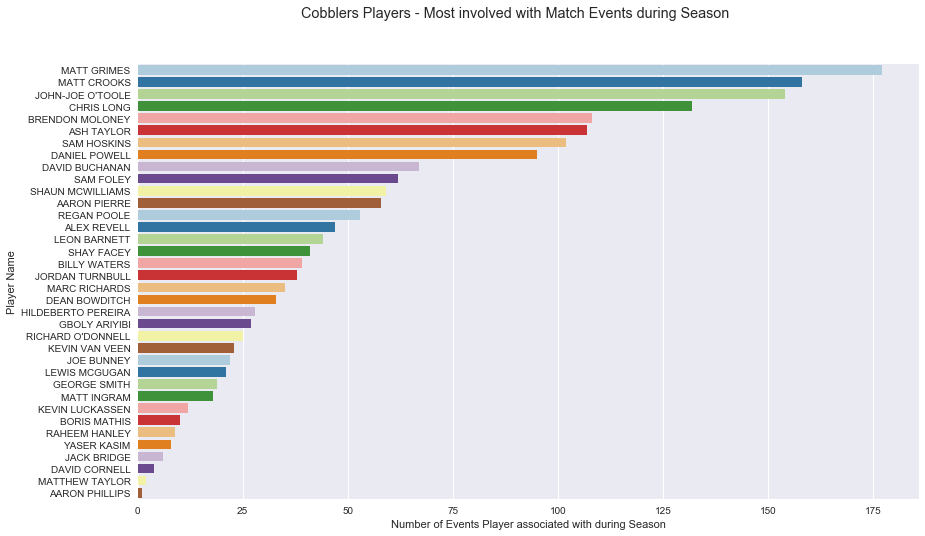

In [30]:
from matplotlib.pyplot import suptitle
plt.figure(figsize=(14,8))
sns.set(font_scale = 1)
evtplt = sns.countplot(y='event_player', data=play_data, palette="Paired",
                       order = play_data['event_player'].value_counts().sort_values(ascending=False).index)
evtplt.set_xlabel("Number of Events Player associated with during Season")
evtplt.set_ylabel("Player Name")
suptitle("Cobblers Players - Most involved with Match Events during Season")
plt.show()

### Analysis of Event Types per "minute" of match

In [31]:
# get all data rows from m_data, where timing is between 0 and 90 mins (ie. not added on time)
pivot_m = pd.DataFrame(m_data[["event_type","H_A","Timing"]])
# create a pivot table for events / timing (ie. minute that event occurred during matches)
pivot_evts = pd.DataFrame(pd.pivot_table(pivot_m,index=["event_type","H_A"],columns="Timing",aggfunc=len, fill_value=0))
# pivot_evts.columns = pivot_evts.columns.droplevel()
# pivot_evts.columns.name = None
# pivot_evts.reset_index(inplace=True)
pivot_evts.head()

Timing                  1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
event_type        H_A                                                          
CORNER COBBLERS   AWAY     0     1     0     0     4     3     1     1     0   
                  HOME     1     1     0     0     0     1     0     0     0   
CORNER OPPOSITION AWAY     0     1     2     2     1     3     0     1     0   
                  HOME     1     3     1     0     1     1     2     4     1   
FOUL COBBLERS     AWAY     4     4     1     5     2     1     2     1     3   

Timing                  10.0  ...   82.0  83.0  84.0  85.0  86.0  87.0  88.0  \
event_type        H_A         ...                                              
CORNER COBBLERS   AWAY     0  ...      4     1     0     1     2     3     1   
                  HOME     3  ...      1     1     2     3     2     0     0   
CORNER OPPOSITION AWAY     2  ...      7     0     2     5     2     2     4   
                  HOME     2  ...      3     1     2     1     2     2     4   
FOUL COBBLERS     AWAY     2  ...      1     5     4     5     1     4     2   

Timing                  89.0  90.0  91.0  
event_type        H_A                     
CORNER COBBLERS   AWAY     0     0     1  
                  HOME     1     0     7  
CORNER OPPOSITION AWAY     1     2     2  
                  HOME     3     2     7  
FOUL COBBLERS     AWAY     1     6    14  

[5 rows x 92 columns]

In [32]:
# query just HOME figures within PIVOT_EVTS pivot table
pivot_home = pivot_evts.xs('HOME', level='H_A')
# query just AWAY figures within PIVOT_EVTS pivot table
pivot_away = pivot_evts.xs('AWAY', level='H_A')
print("pivot_home : rows = "+ str(pivot_home.shape[0]))
print("pivot_away : rows = "+ str(pivot_away.shape[0]))

pivot_home : rows = 25
pivot_away : rows = 24


### Heatmaps :- Event Types for each minute of match

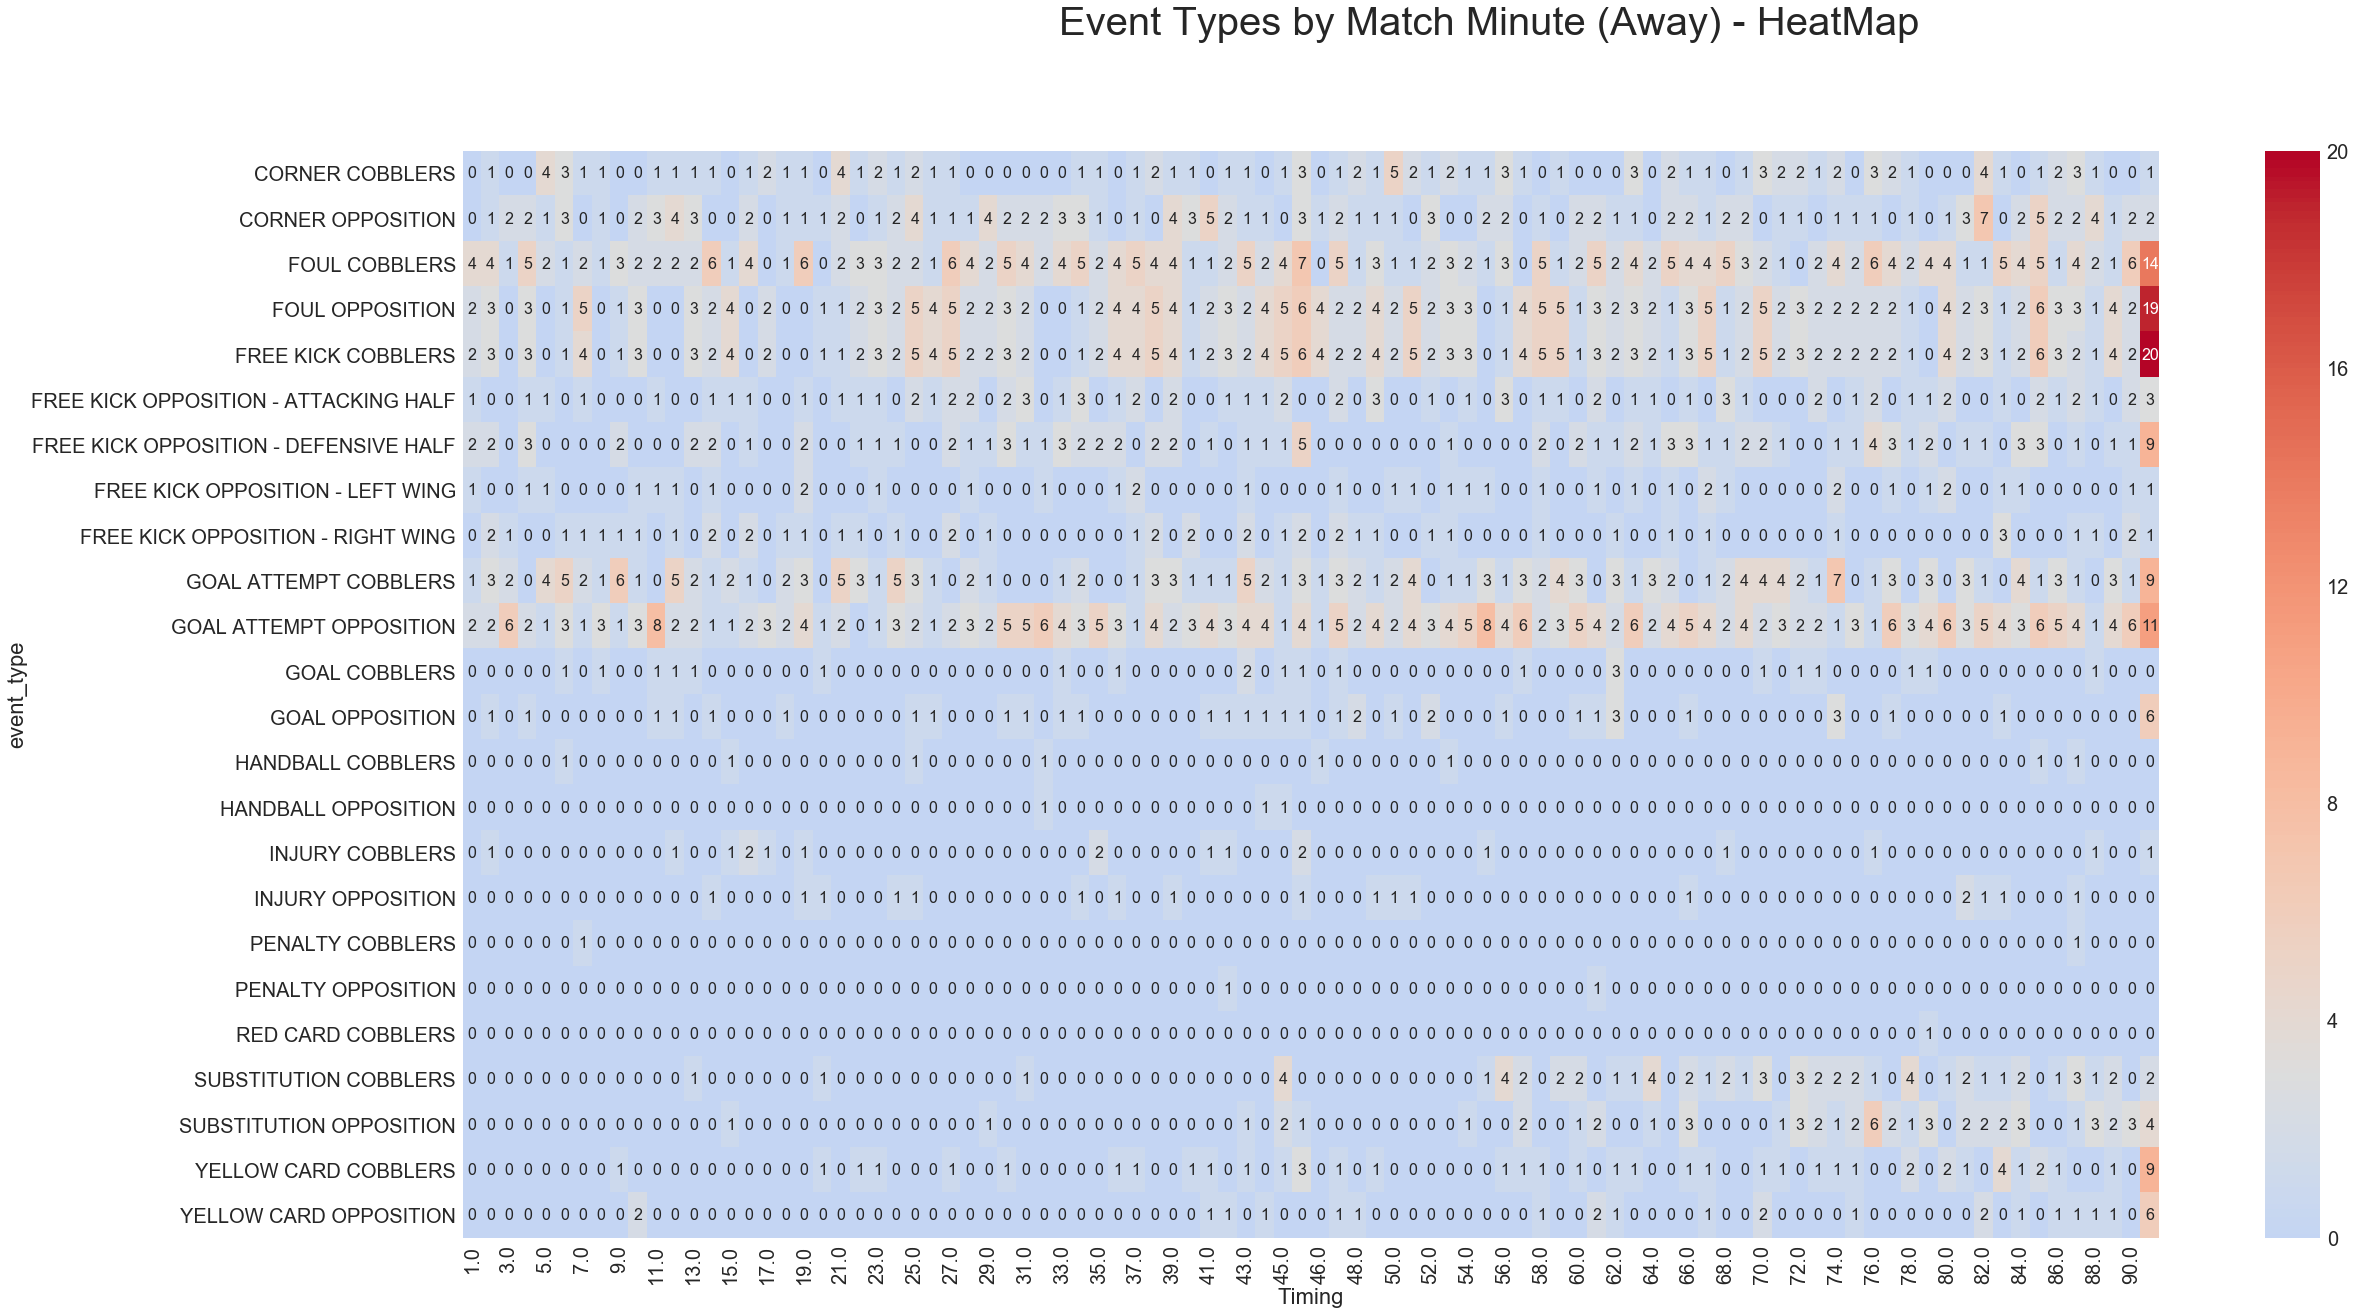

In [33]:
from matplotlib.pyplot import suptitle
fig = plt.figure(figsize=(38,20))
sns.set(font_scale = 2)
sns.heatmap(pivot_away, annot=True, cmap="coolwarm", annot_kws={'size':16}, center=3)
# sns.heatmap(pivot_away, annot=True, center=3)
suptitle("Event Types by Match Minute (Away) - HeatMap", size=40)
plt.show()
fig.savefig('heatmap_away.png')

- For above heatmap, RED colours indicate high frequency, BLUE colours low frequency.
- X axis shows the Minute during a match (ie. minute 1 through to 90)
  *Events occurring in first half injury time, are assigned 45.5 as their timing. 
   For second half injury time, it is 91.
- Y axis shows each type of event occurring in a match

#### Analysis
- High frequency of events occurring in the 90th+ minute of a game (and similar frequencies around 45th minute)

- More red coloured squares where timing > 45. Indicating more activity in the second half. This relates to Fouls / Free Kicks and Goal Attempts for both teams.


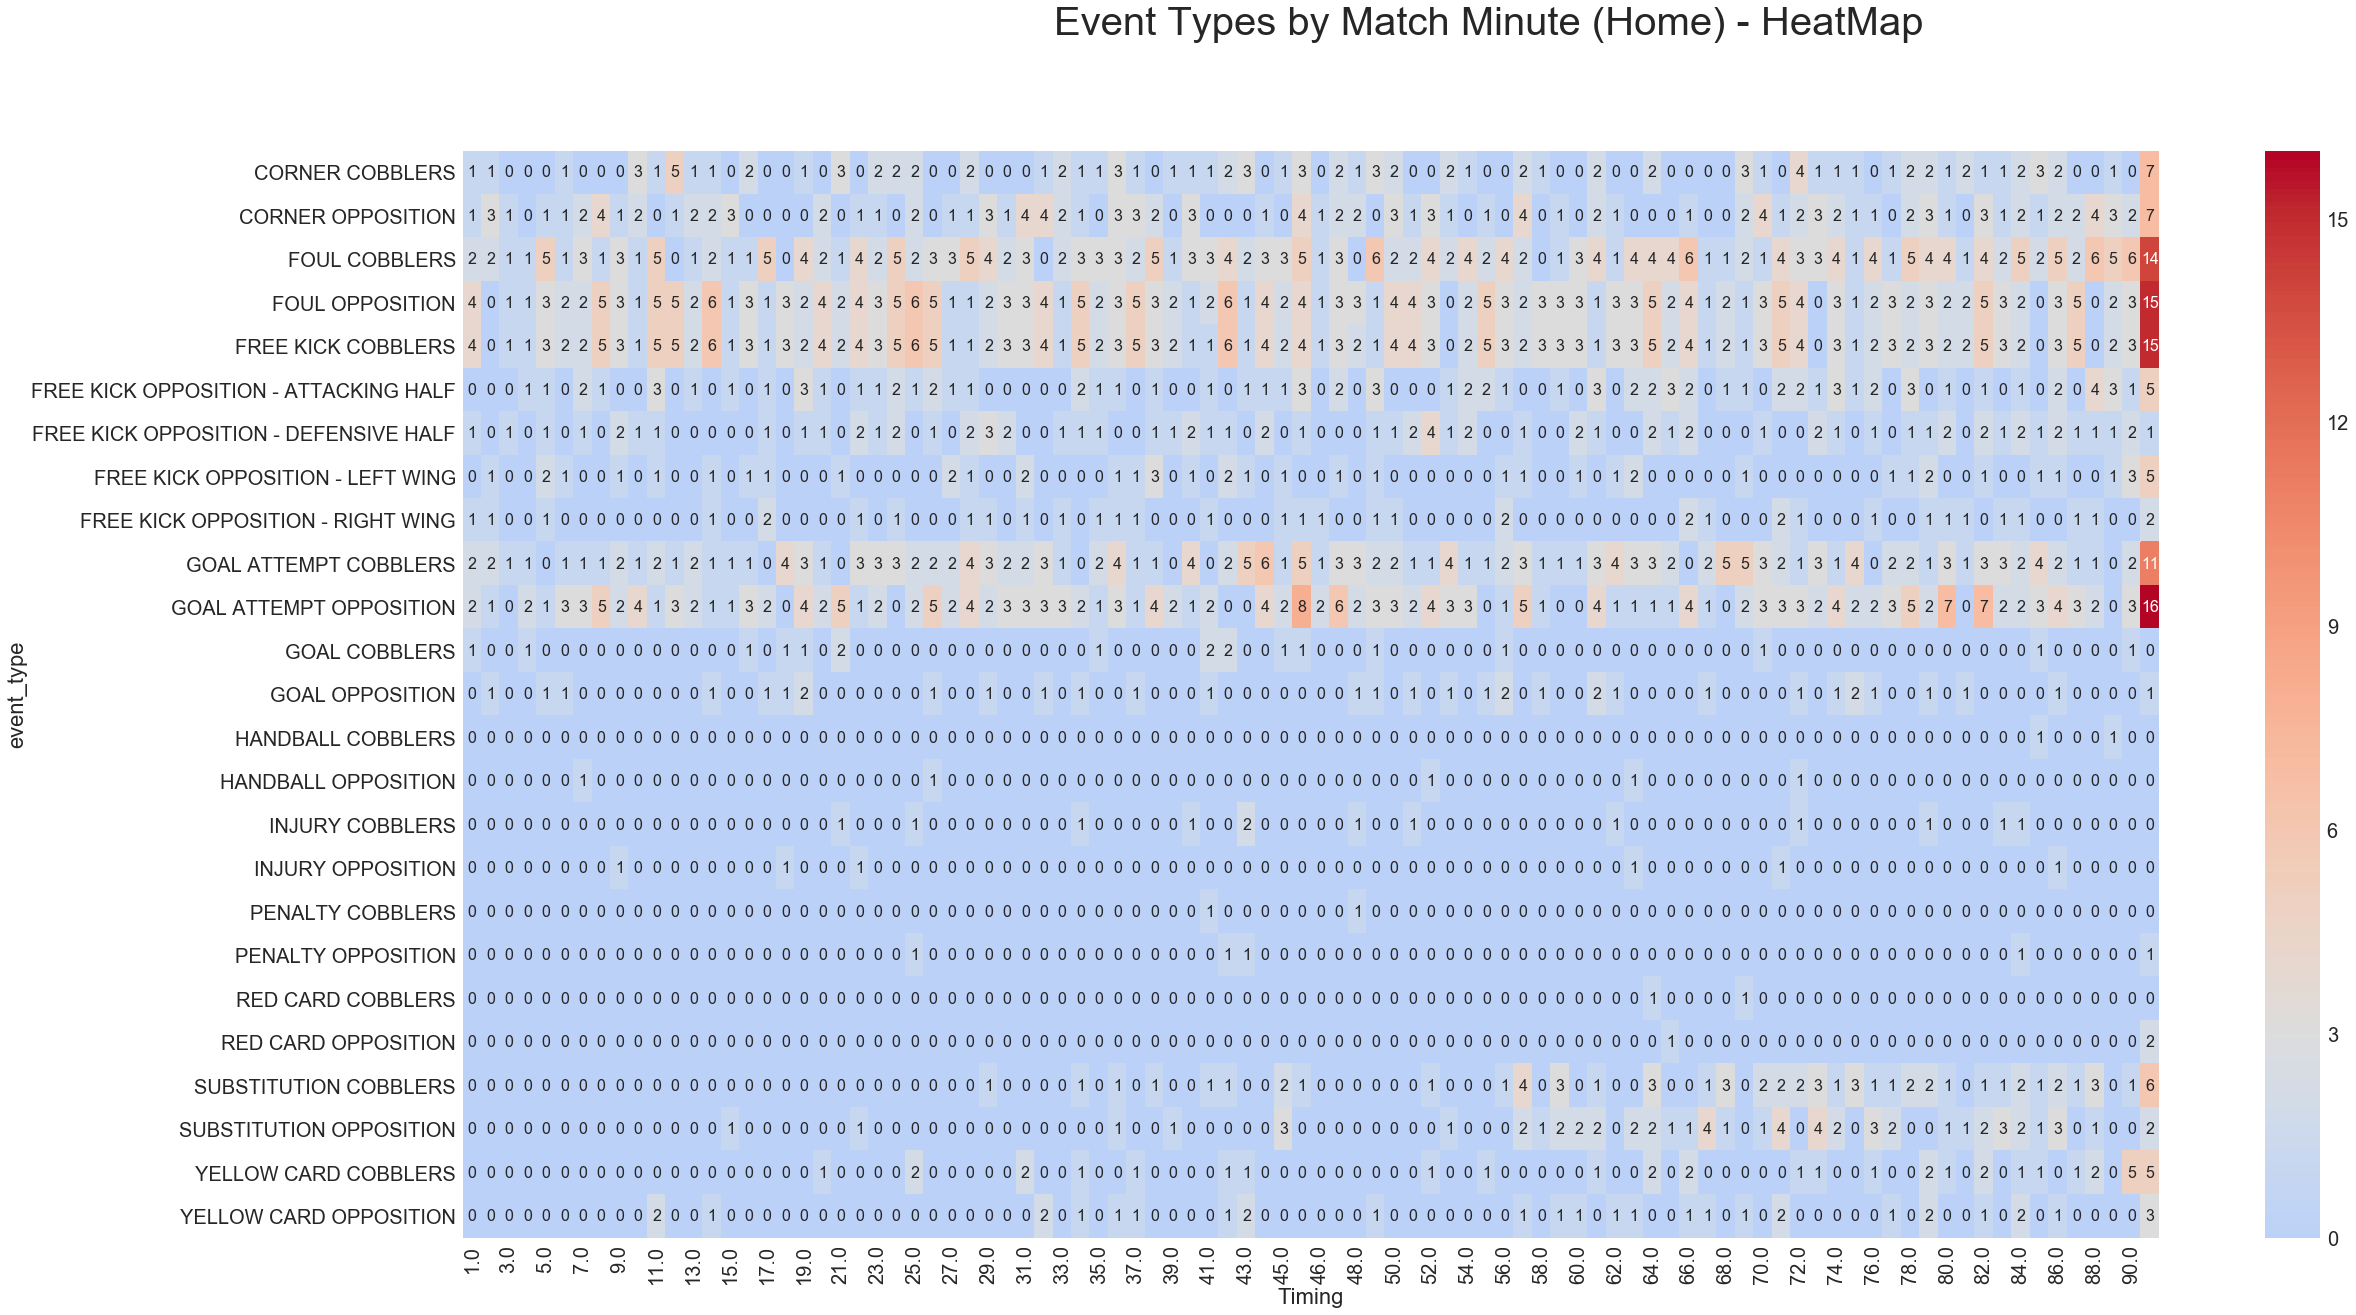

In [34]:
fig = plt.figure(figsize=(38,20))
plt.rcParams['font.size'] = 30
sns.set(font_scale = 2)
sns.heatmap(pivot_home, annot=True, cmap="coolwarm", annot_kws={'size':16}, center=3)
suptitle("Event Types by Match Minute (Home) - HeatMap", size=40)
fig.savefig('heatmap_home.png')

- For above heatmap, RED colours indicate high frequency, BLUE colours low frequency.
- X axis shows the Minute during a match (ie. minute 1 through to 90)
- Y axis shows each type of event occurring in a match

### Analysis
- Again a heavy bias of activity centering around both ends of the half (45 + 90 mins)
- More red coloured squares where timing > 45. Indicating more activity in the second half. This relates to Fouls / Free Kicks and Goal Attempts for both teams.

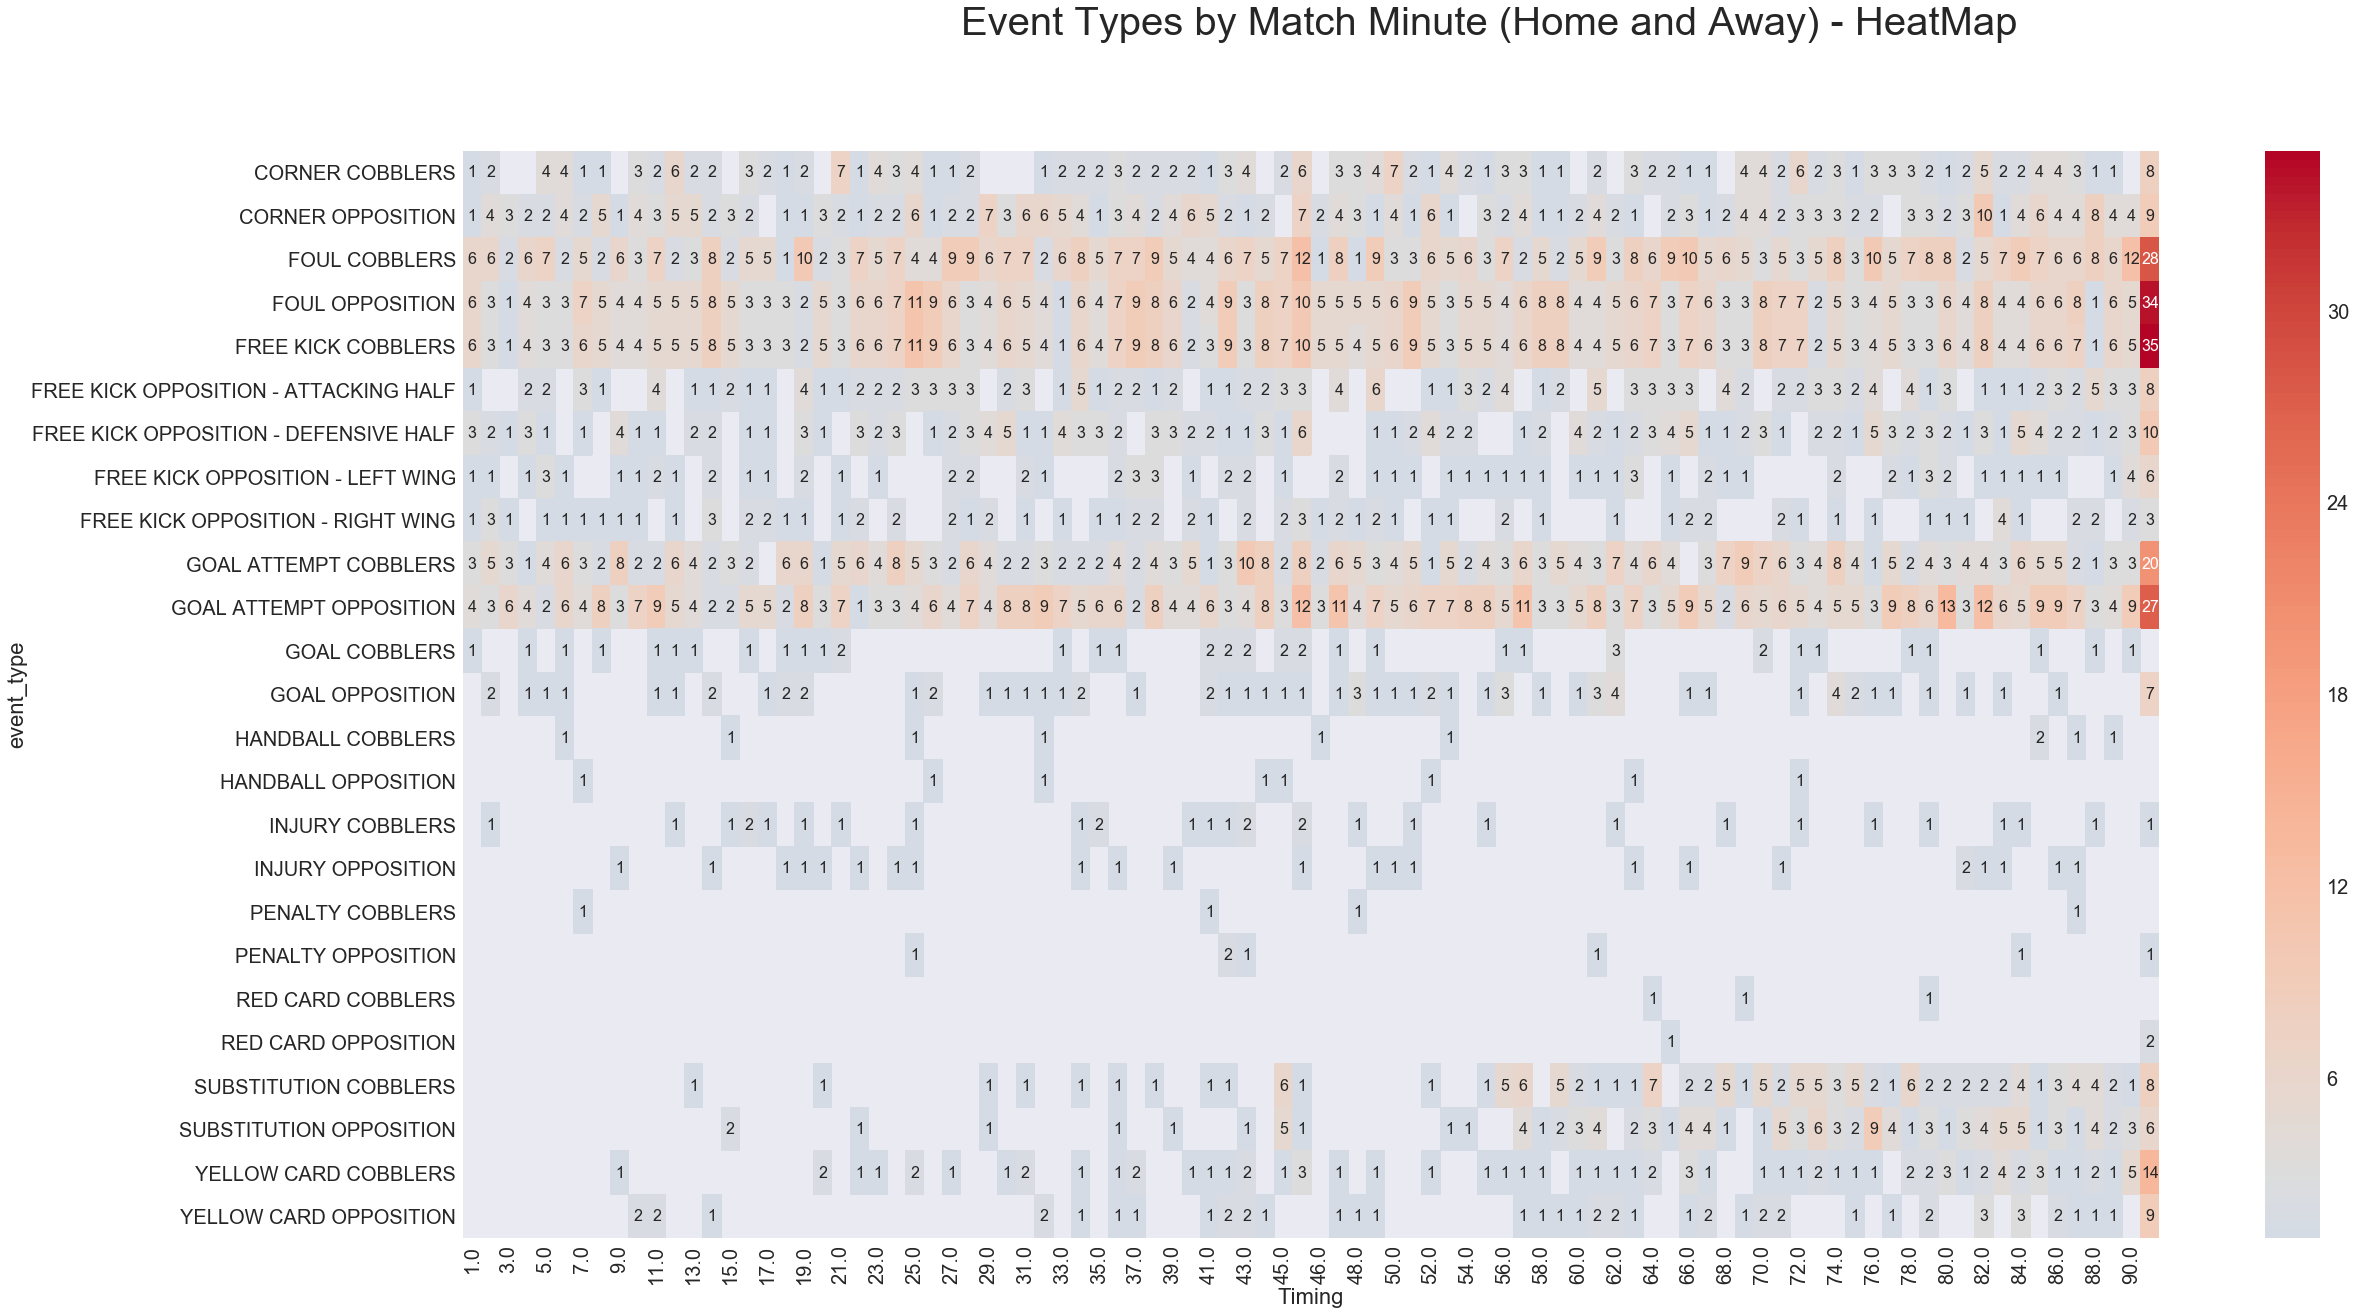

In [35]:
# get all data rows from m_data, where timing is between 0 and 90 mins (ie. not added on time)
pivot_m2 = m_data[["event_type","Timing"]]
pivot_evts2 = pd.DataFrame(pd.pivot_table(pivot_m2,index=["event_type"],columns="Timing",aggfunc=len))
pivot_evts2
from matplotlib.pyplot import suptitle
fig = plt.figure(figsize=(38,20))
sns.set(font_scale = 2)
sns.heatmap(pivot_evts2, annot=True, cmap="coolwarm", annot_kws={'size':16}, center=3)
suptitle("Event Types by Match Minute (Home and Away) - HeatMap", size=40)
plt.show()
fig.savefig('heatmap_homeaway.png')

- For above heatmap, RED colours indicate high frequency, BLUE colours low frequency.
- X axis shows the Minute during a match (ie. minute 1 through to 90)
- Y axis shows each type of event occurring in a match

### Analysis
 - Both Home and Away, the most significant action occurs at the end of the game (90+ minutes), with both Goal Attempts and Fouls / Free Kicks featuring heavily.

### Swarm Plot :- Event Types per minute of match

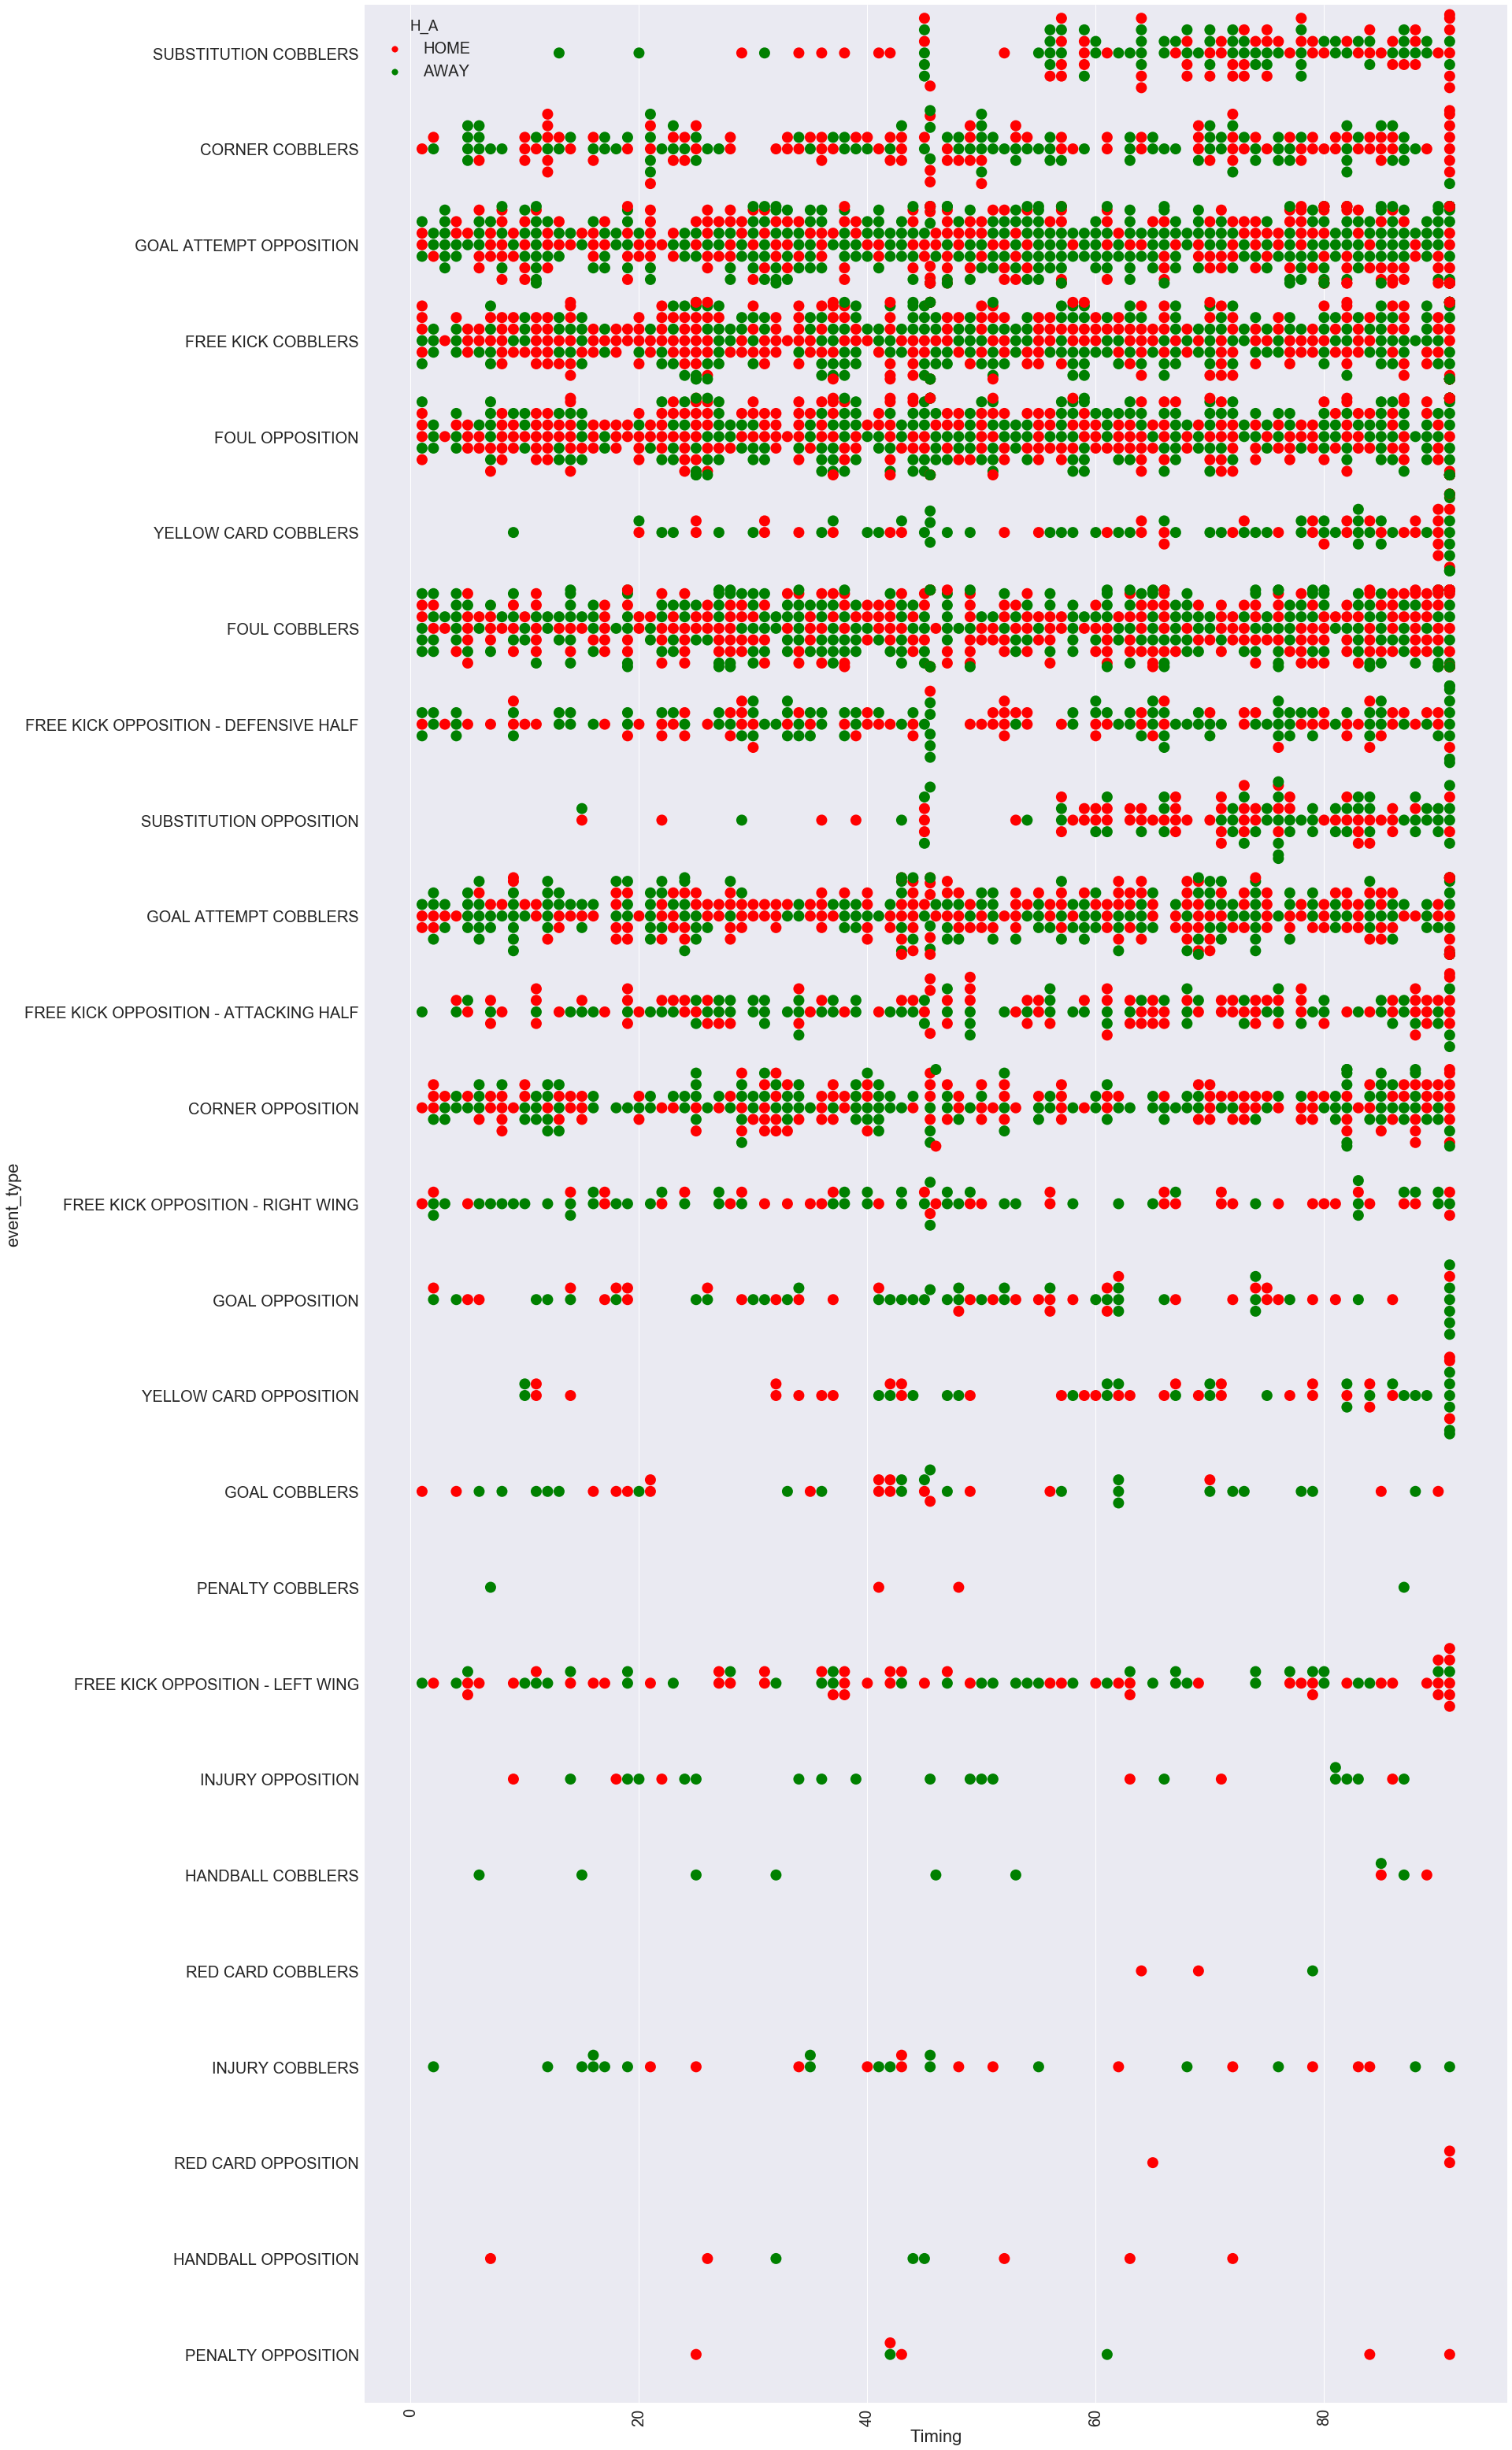

In [37]:
fig = plt.figure(figsize=(26,56))
colours=["red","green"]
sns.set_style("dark")
sns.set(font_scale = 2)
sns.swarmplot(y="event_type", x="Timing", 
              hue="H_A", 
              data=m_data, palette=colours, size=14);
plt.setp(plt.gca().get_xticklabels(), rotation=90)
fig.savefig('swarmplot_All.png')

### Analysis 

Swarmplot visualisation, showing when types of events occur during matches

    - Red dots = Events occurring in Home games
    - Green dots = Events occurring in Away games

X axis indicates the minute of the match, Y axis are each match event type. The more activity or events occurring in a minute of the game, the more dense/populated the chart will be with red or green dots.

In [38]:
subset_Corner_Oppo=pd.DataFrame(m_data[(m_data['event_type']=="CORNER OPPOSITION")])
subset_Goal_Oppo=pd.DataFrame(m_data[(m_data['event_type']=="GOAL OPPOSITION")])
subset_Goal_Cobbs=pd.DataFrame(m_data[(m_data['event_type']=="GOAL COBBLERS")])
subset_GAtt_Oppo=pd.DataFrame(m_data[(m_data['event_type']=="GOAL ATTEMPT OPPOSITION")])
subset_GAtt_Cobbs=pd.DataFrame(m_data[(m_data['event_type']=="GOAL ATTEMPT COBBLERS")])

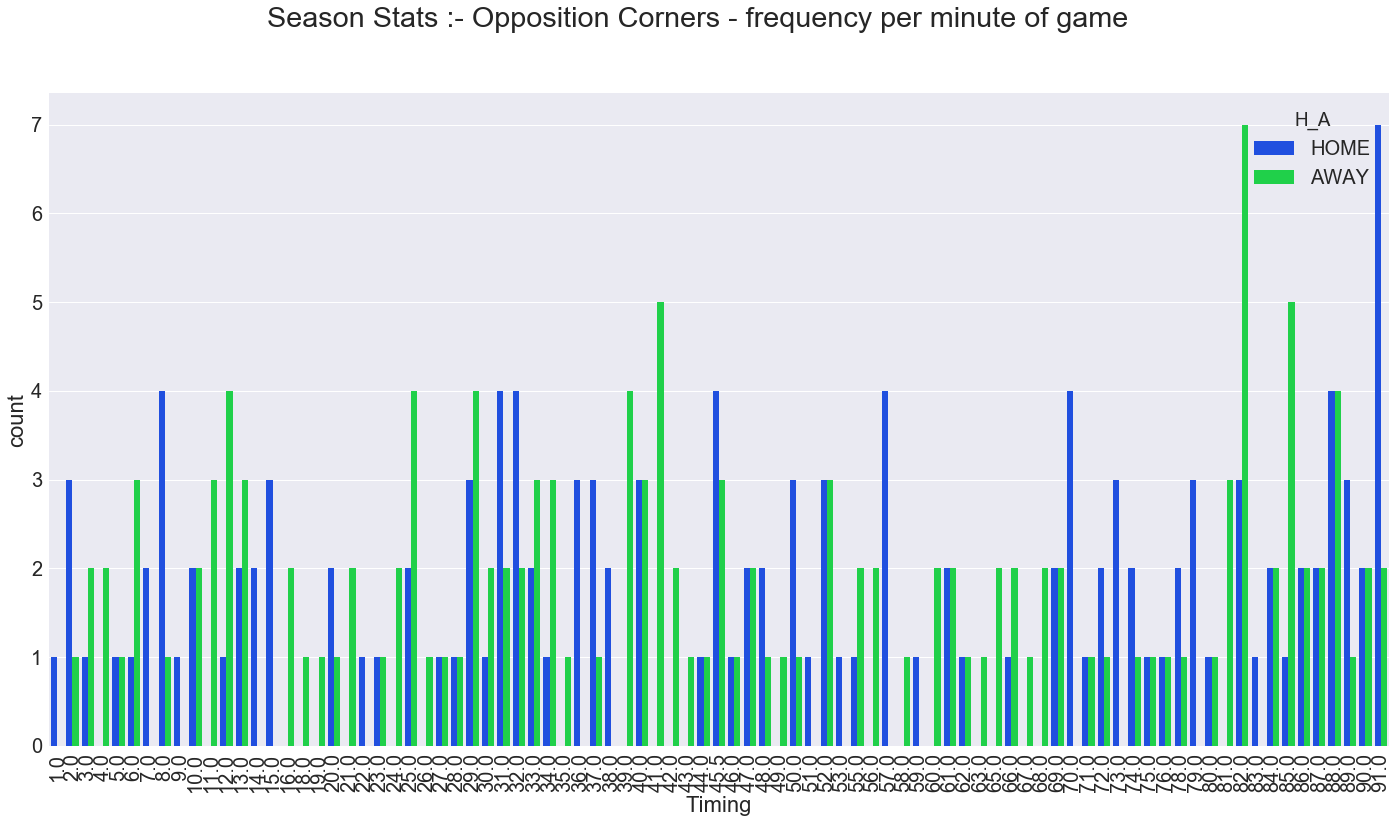

In [39]:
plt.figure(figsize=(24,12))
# sns.set(font_scale = 1.5)
evtplt = sns.countplot(x='Timing', data=subset_Corner_Oppo, hue='H_A', palette="bright")
plt.setp(plt.gca().get_xticklabels(), rotation=90)
# evtplt.set_xticklabels(evtplt.get_xticklabels(), rotation=90, ha="right")
suptitle("Season Stats :- Opposition Corners - frequency per minute of game")
plt.show()

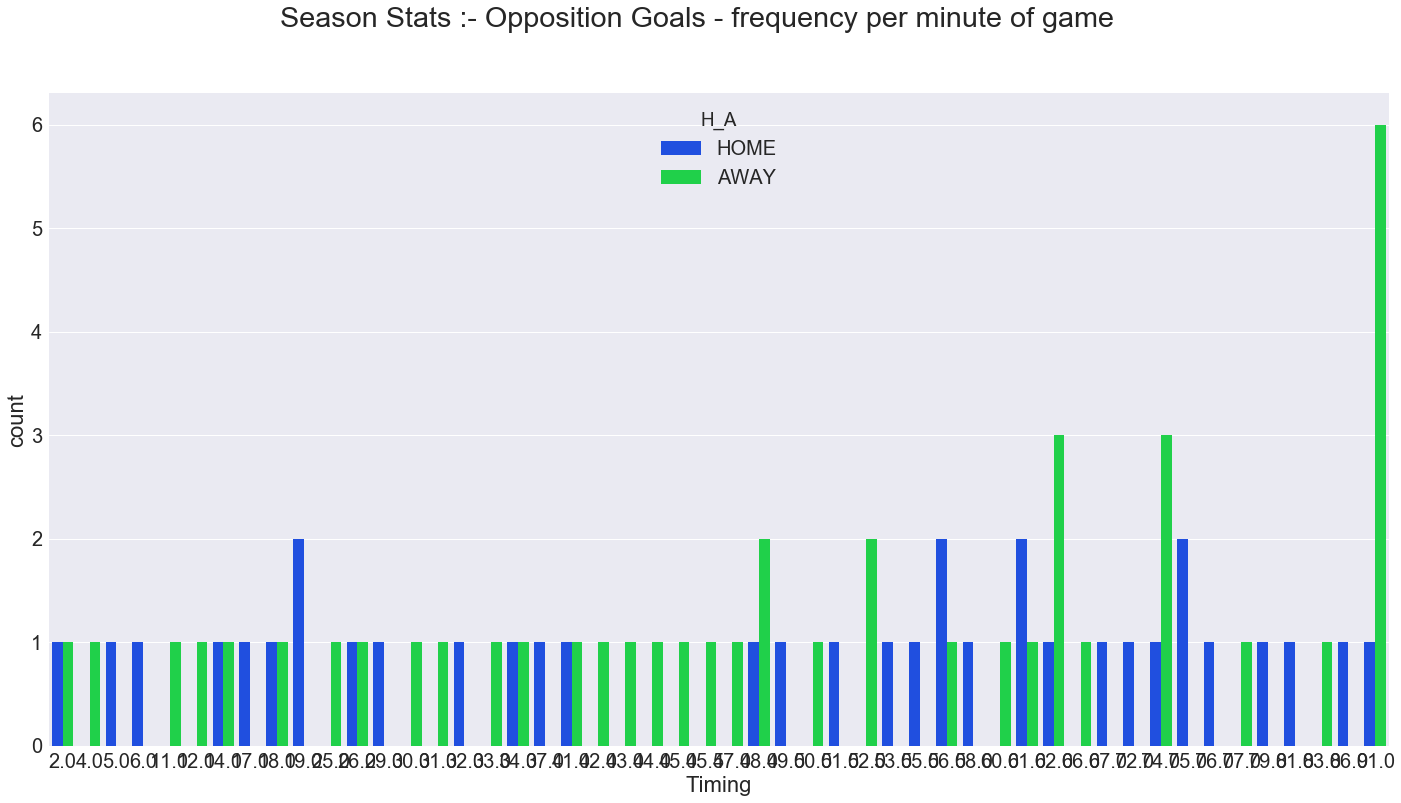

In [40]:
plt.figure(figsize=(24,12))
evtplt = sns.countplot(x='Timing', data=subset_Goal_Oppo, hue='H_A', palette="bright")
suptitle("Season Stats :- Opposition Goals - frequency per minute of game")
plt.show()

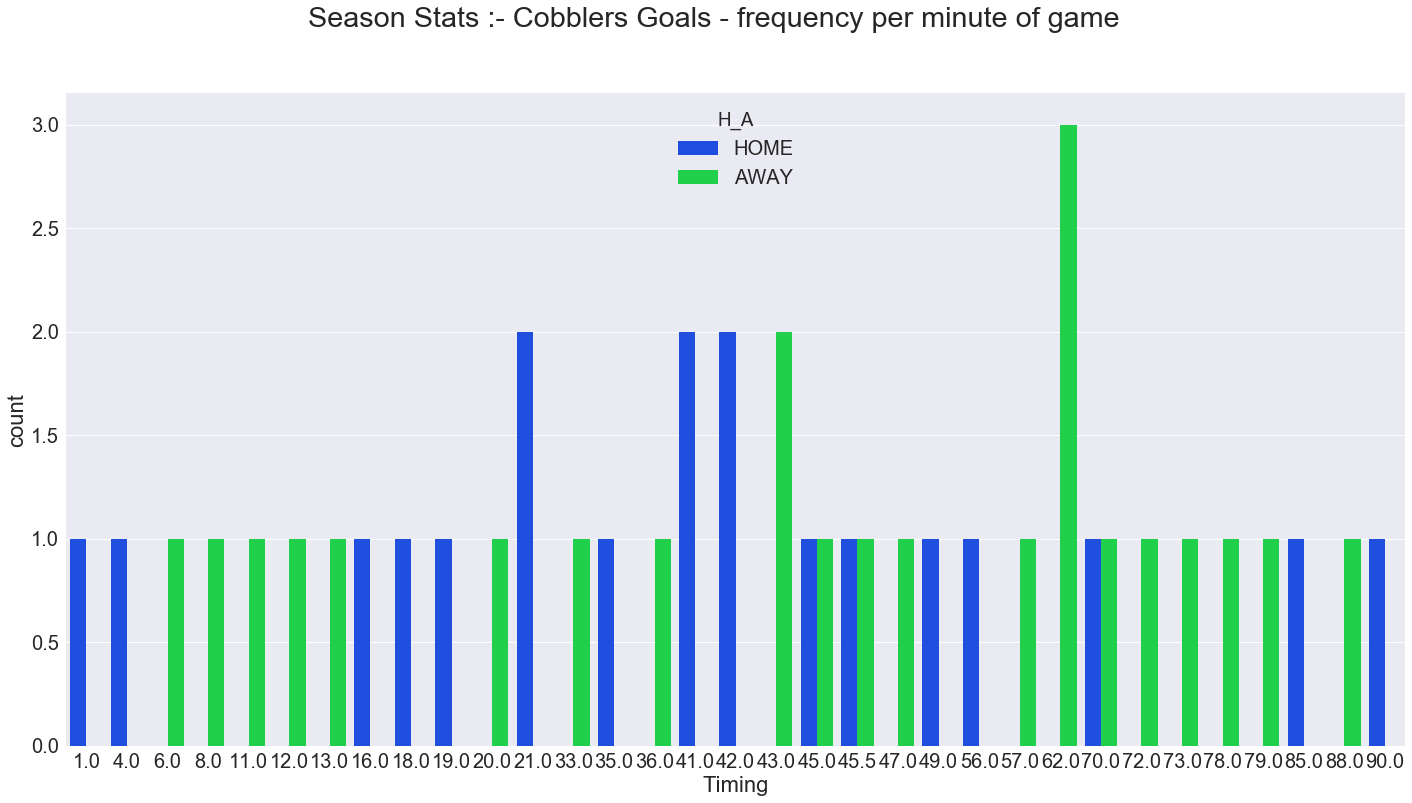

In [41]:
plt.figure(figsize=(24,12))
evtplt = sns.countplot(x='Timing', data=subset_Goal_Cobbs, hue='H_A', palette="bright")
suptitle("Season Stats :- Cobblers Goals - frequency per minute of game")
plt.show()

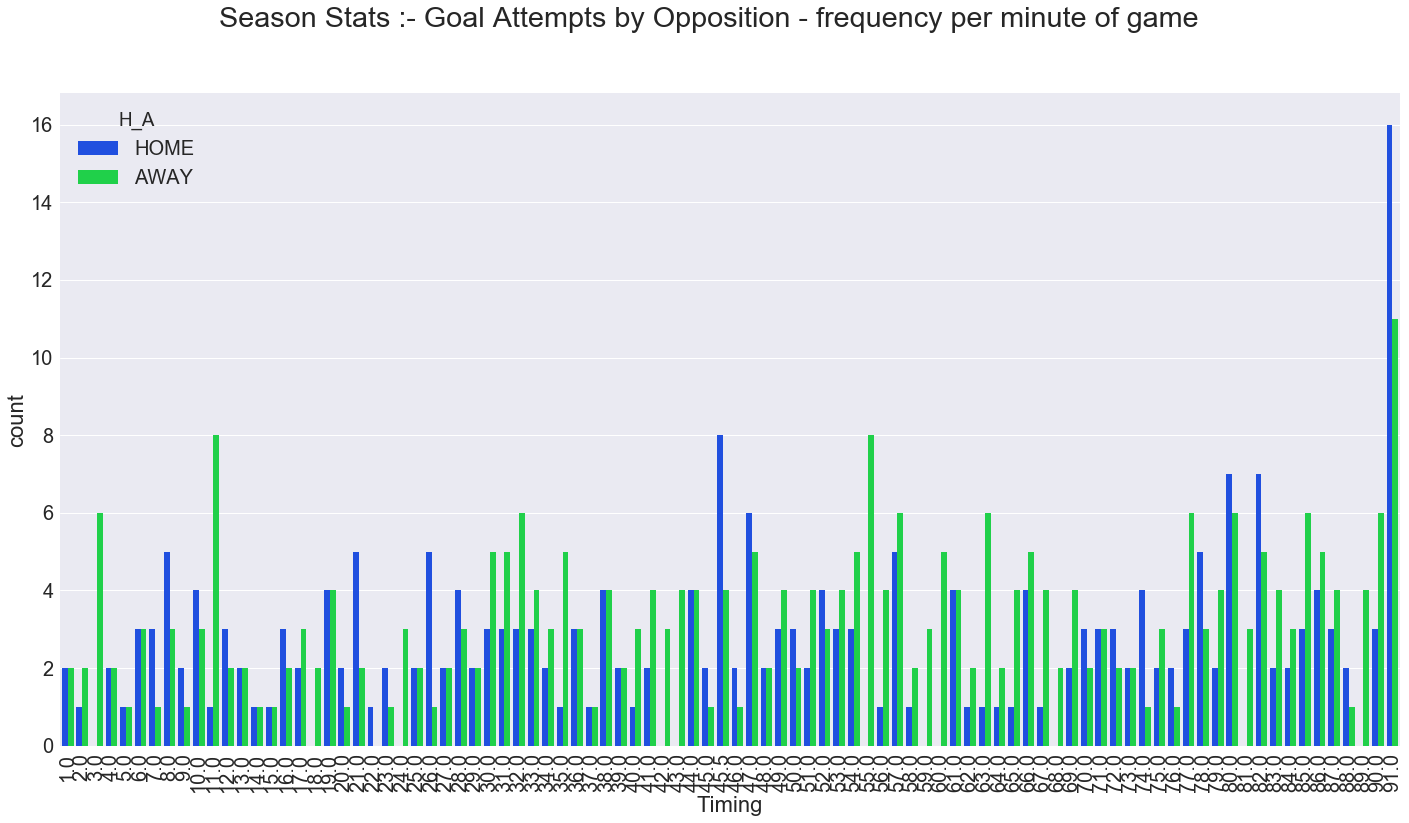

In [42]:
plt.figure(figsize=(24,12))
evtplt = sns.countplot(x='Timing', data=subset_GAtt_Oppo, hue='H_A', palette="bright")
plt.setp(plt.gca().get_xticklabels(), rotation=90)
suptitle("Season Stats :- Goal Attempts by Opposition - frequency per minute of game")
plt.show()

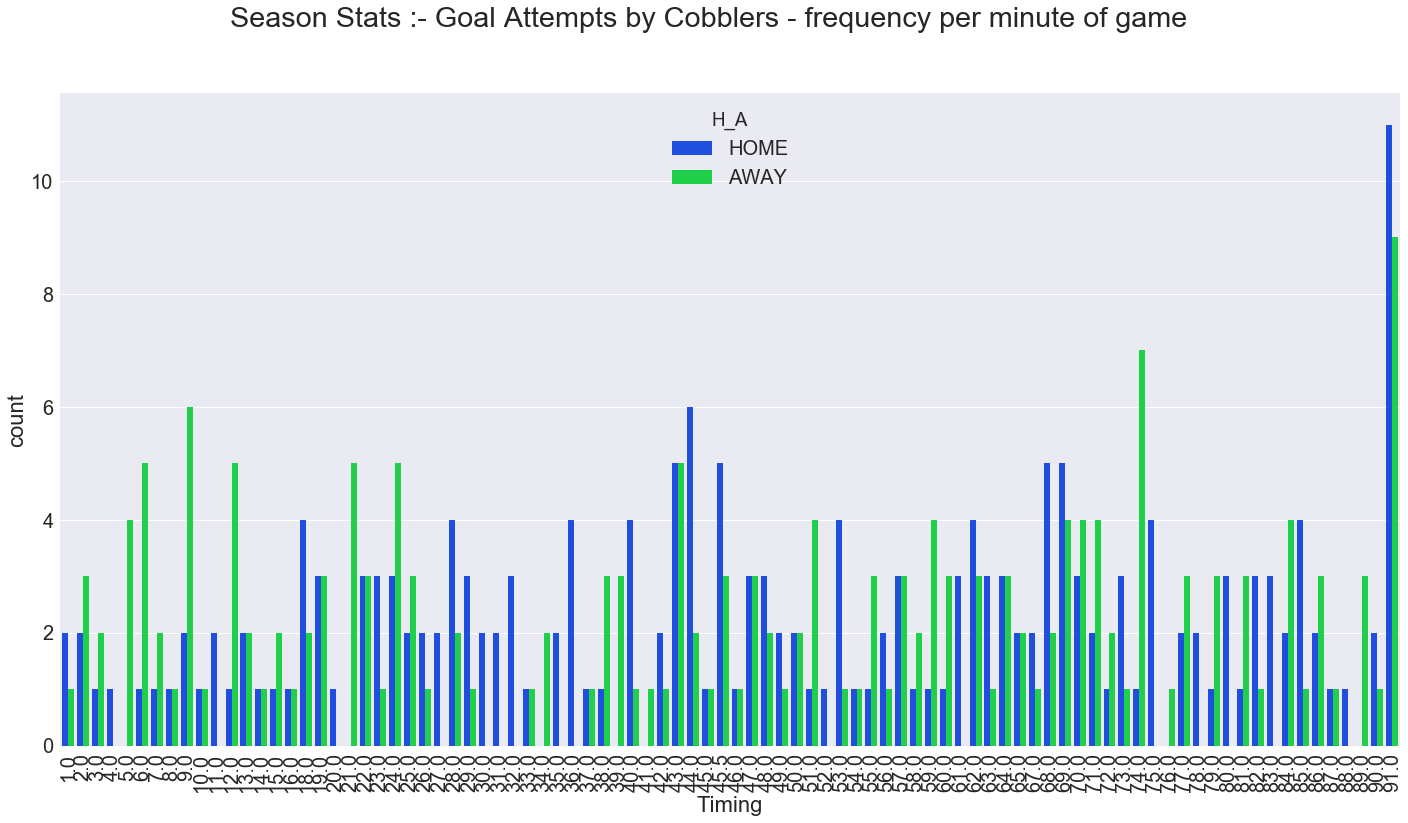

In [43]:
plt.figure(figsize=(24,12))
evtplt = sns.countplot(x='Timing', data=subset_GAtt_Cobbs, hue='H_A', palette="bright")
plt.setp(plt.gca().get_xticklabels(), rotation=90)
suptitle("Season Stats :- Goal Attempts by Cobblers - frequency per minute of game")
plt.show()

In [44]:
m_data.head()

,Timing,Event,event_type,H_A,added_time,match_date,event_player,match_id,Min_Range
2,91.0,"SUBSTITUTION, NORTHAMPTON TOWN. MORGAN ROBERTS...",SUBSTITUTION COBBLERS,HOME,6,2018-05-05,NONE,1,90+
3,91.0,"CORNER, NORTHAMPTON TOWN. CONCEDED BY ROB HUNT.",CORNER COBBLERS,HOME,3,2018-05-05,NONE,1,90+
4,91.0,ATTEMPT SAVED. CRAIG DAVIES (OLDHAM ATHLETIC) ...,GOAL ATTEMPT OPPOSITION,HOME,1,2018-05-05,NONE,1,90+
5,91.0,ATTEMPT BLOCKED. CRAIG DAVIES (OLDHAM ATHLETIC...,GOAL ATTEMPT OPPOSITION,HOME,1,2018-05-05,NONE,1,90+
6,87.0,MATT GRIMES (NORTHAMPTON TOWN) WINS A FREE KIC...,FREE KICK COBBLERS,HOME,0,2018-05-05,MATT GRIMES,1,76-90 mins


In [45]:
# get all data rows from m_data, where timing is between 0 and 90 mins (ie. not added on time)
# pivot_m2 = m_data[(m_data['added_time']==0)]
pivot_m2 = pd.DataFrame(m_data[["event_type","H_A","Min_Range"]])
# create a pivot table for events / timing (ie. minute that event occurred during matches)
pivot_evts2 = pd.DataFrame(pd.pivot_table(pivot_m2,index=["event_type","H_A"],columns="Min_Range",aggfunc=len, fill_value=0))
pivot_evts2.head()

Min_Range               1-15 mins  16-30 mins  31-45 mins  45+  46-60 mins  \
event_type        H_A                                                        
CORNER COBBLERS   AWAY         14          17          10    3          21   
                  HOME         14          14          18    3          14   
CORNER OPPOSITION AWAY         22          23          28    3          16   
                  HOME         24          12          23    4          19   
FOUL COBBLERS     AWAY         38          41          49    7          30   

Min_Range               61-75 mins  76-90 mins  90+  
event_type        H_A                                
CORNER COBBLERS   AWAY          18          18    1  
                  HOME          15          18    7  
CORNER OPPOSITION AWAY          17          31    2  
                  HOME          19          27    7  
FOUL COBBLERS     AWAY          45          50   14

In [46]:
# query just HOME figures within PIVOT_EVTS pivot table
pivot_home2 = pivot_evts2.xs('HOME', level='H_A')
# query just AWAY figures within PIVOT_EVTS pivot table
pivot_away2 = pivot_evts2.xs('AWAY', level='H_A')
print("pivot_home : rows = "+ str(pivot_home2.shape[0]))
print("pivot_away : rows = "+ str(pivot_away2.shape[0]))

pivot_home : rows = 25
pivot_away : rows = 24


### Heatmaps
The following heatmaps show the frequency of "event types" during matches for Northampton Town FC, in the 2017/18 League One season.

Low Frequencies = Blue colours
High Frequencies = Red colours


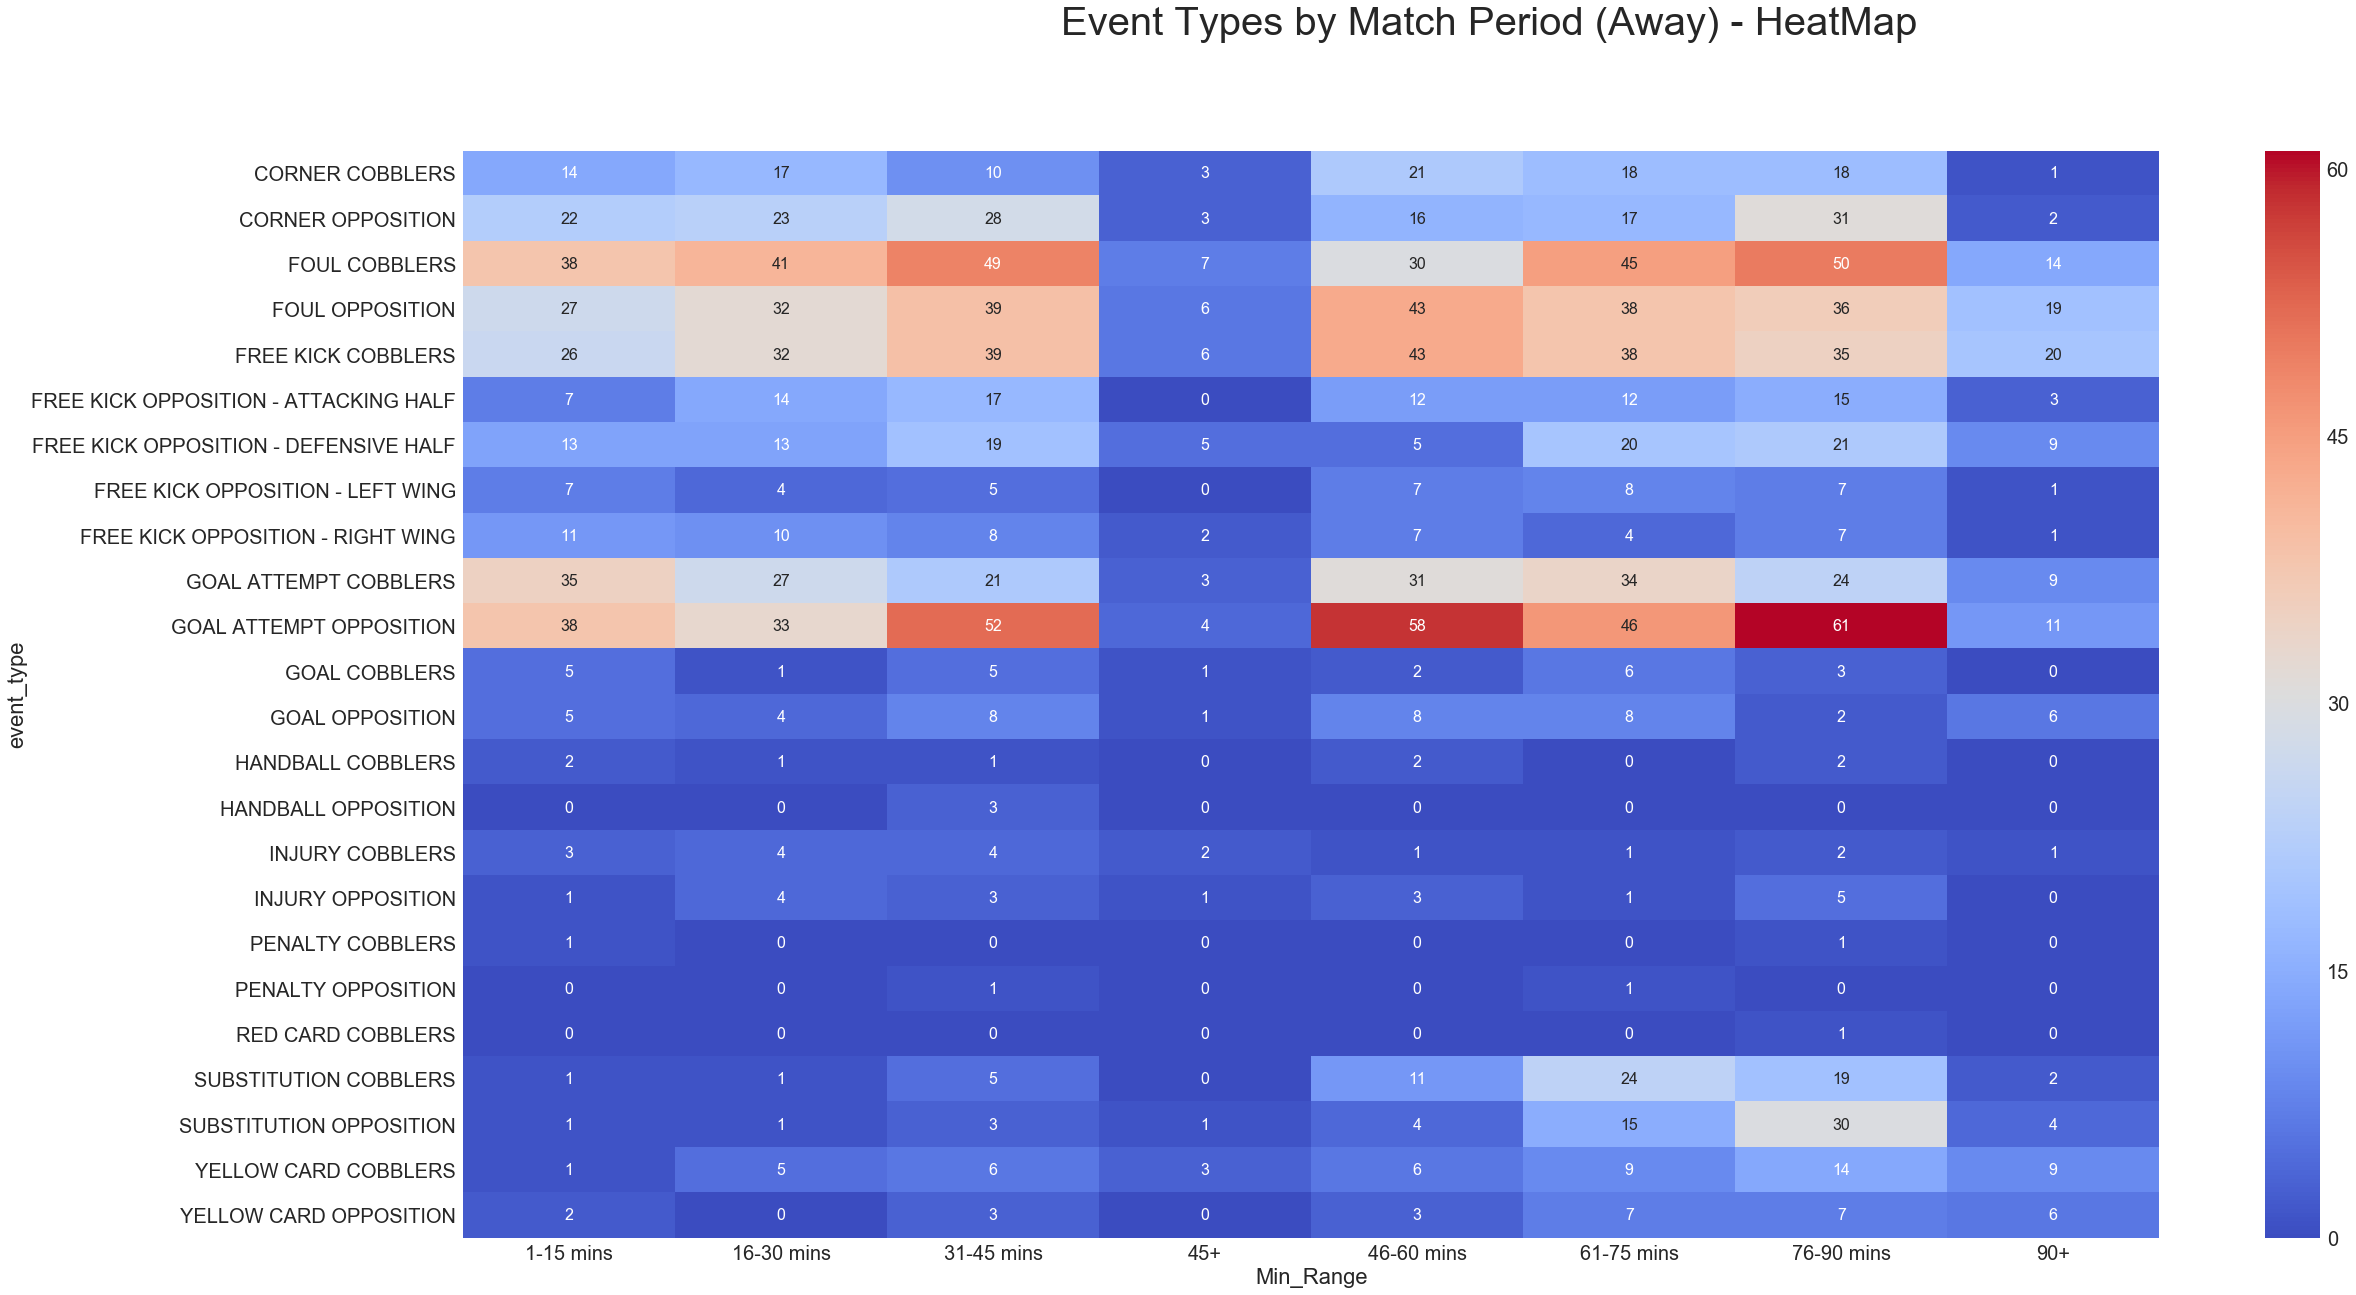

In [47]:
from matplotlib.pyplot import suptitle
fig = plt.figure(figsize=(38,20))
sns.set(font_scale = 2)
sns.heatmap(pivot_away2, annot=True, cmap="coolwarm", annot_kws={'size':16})
# sns.heatmap(pivot_away, annot=True, center=3)
suptitle("Event Types by Match Period (Away) - HeatMap", size=40)
plt.show()
fig.savefig('heatmap_away_2.png')

### Analysis

- Goal Attempts by the opposition, are clearly more frequent during the "31-45th", "46-60th" and "76-90th" minute periods of a game. This is shown by the red squares in the heatmap. Indicating that away from home, Northampton were at their most vulnerable at the ends of each half, and the start of the second.
 

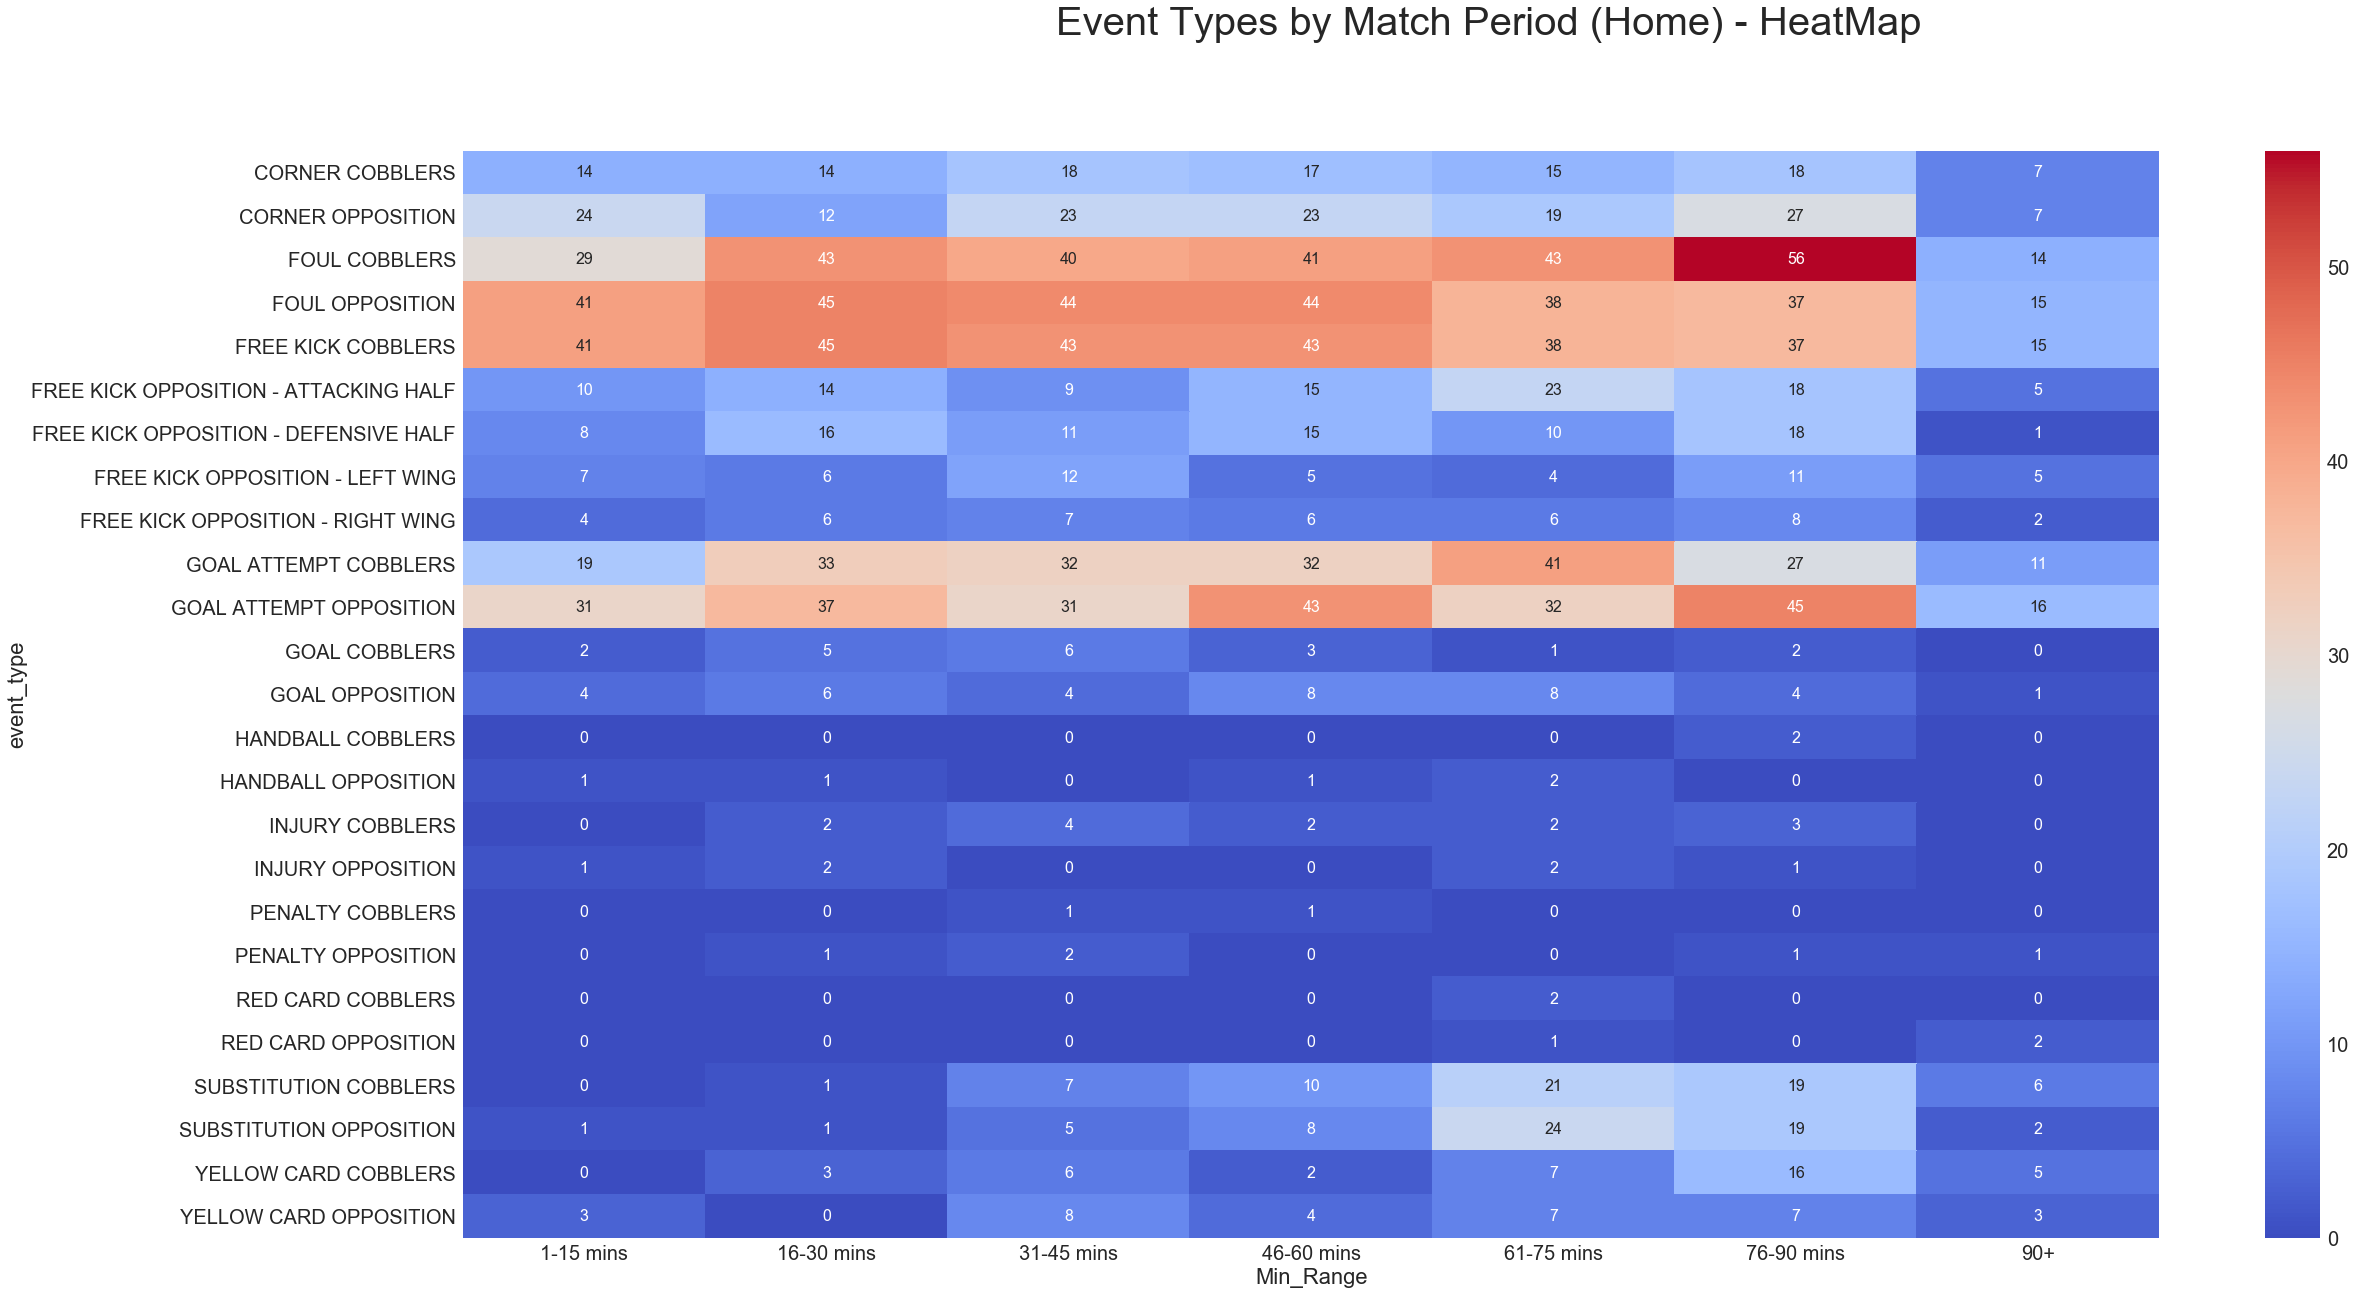

In [256]:
from matplotlib.pyplot import suptitle
fig = plt.figure(figsize=(38,20))
sns.set(font_scale = 2)
sns.heatmap(pivot_home2, annot=True, cmap="coolwarm", annot_kws={'size':16})
# sns.heatmap(pivot_away, annot=True, center=3)
suptitle("Event Types by Match Period (Home) - HeatMap", size=40)
plt.show()
fig.savefig('heatmap_home_2.png')

### Analysis

- Goal attempts by the opposition are still high, and (as with the away games) at the end of both halves. However, they are not as freqent. 
- Fouls by the Cobblers, are high between 76 - 90 minutes.

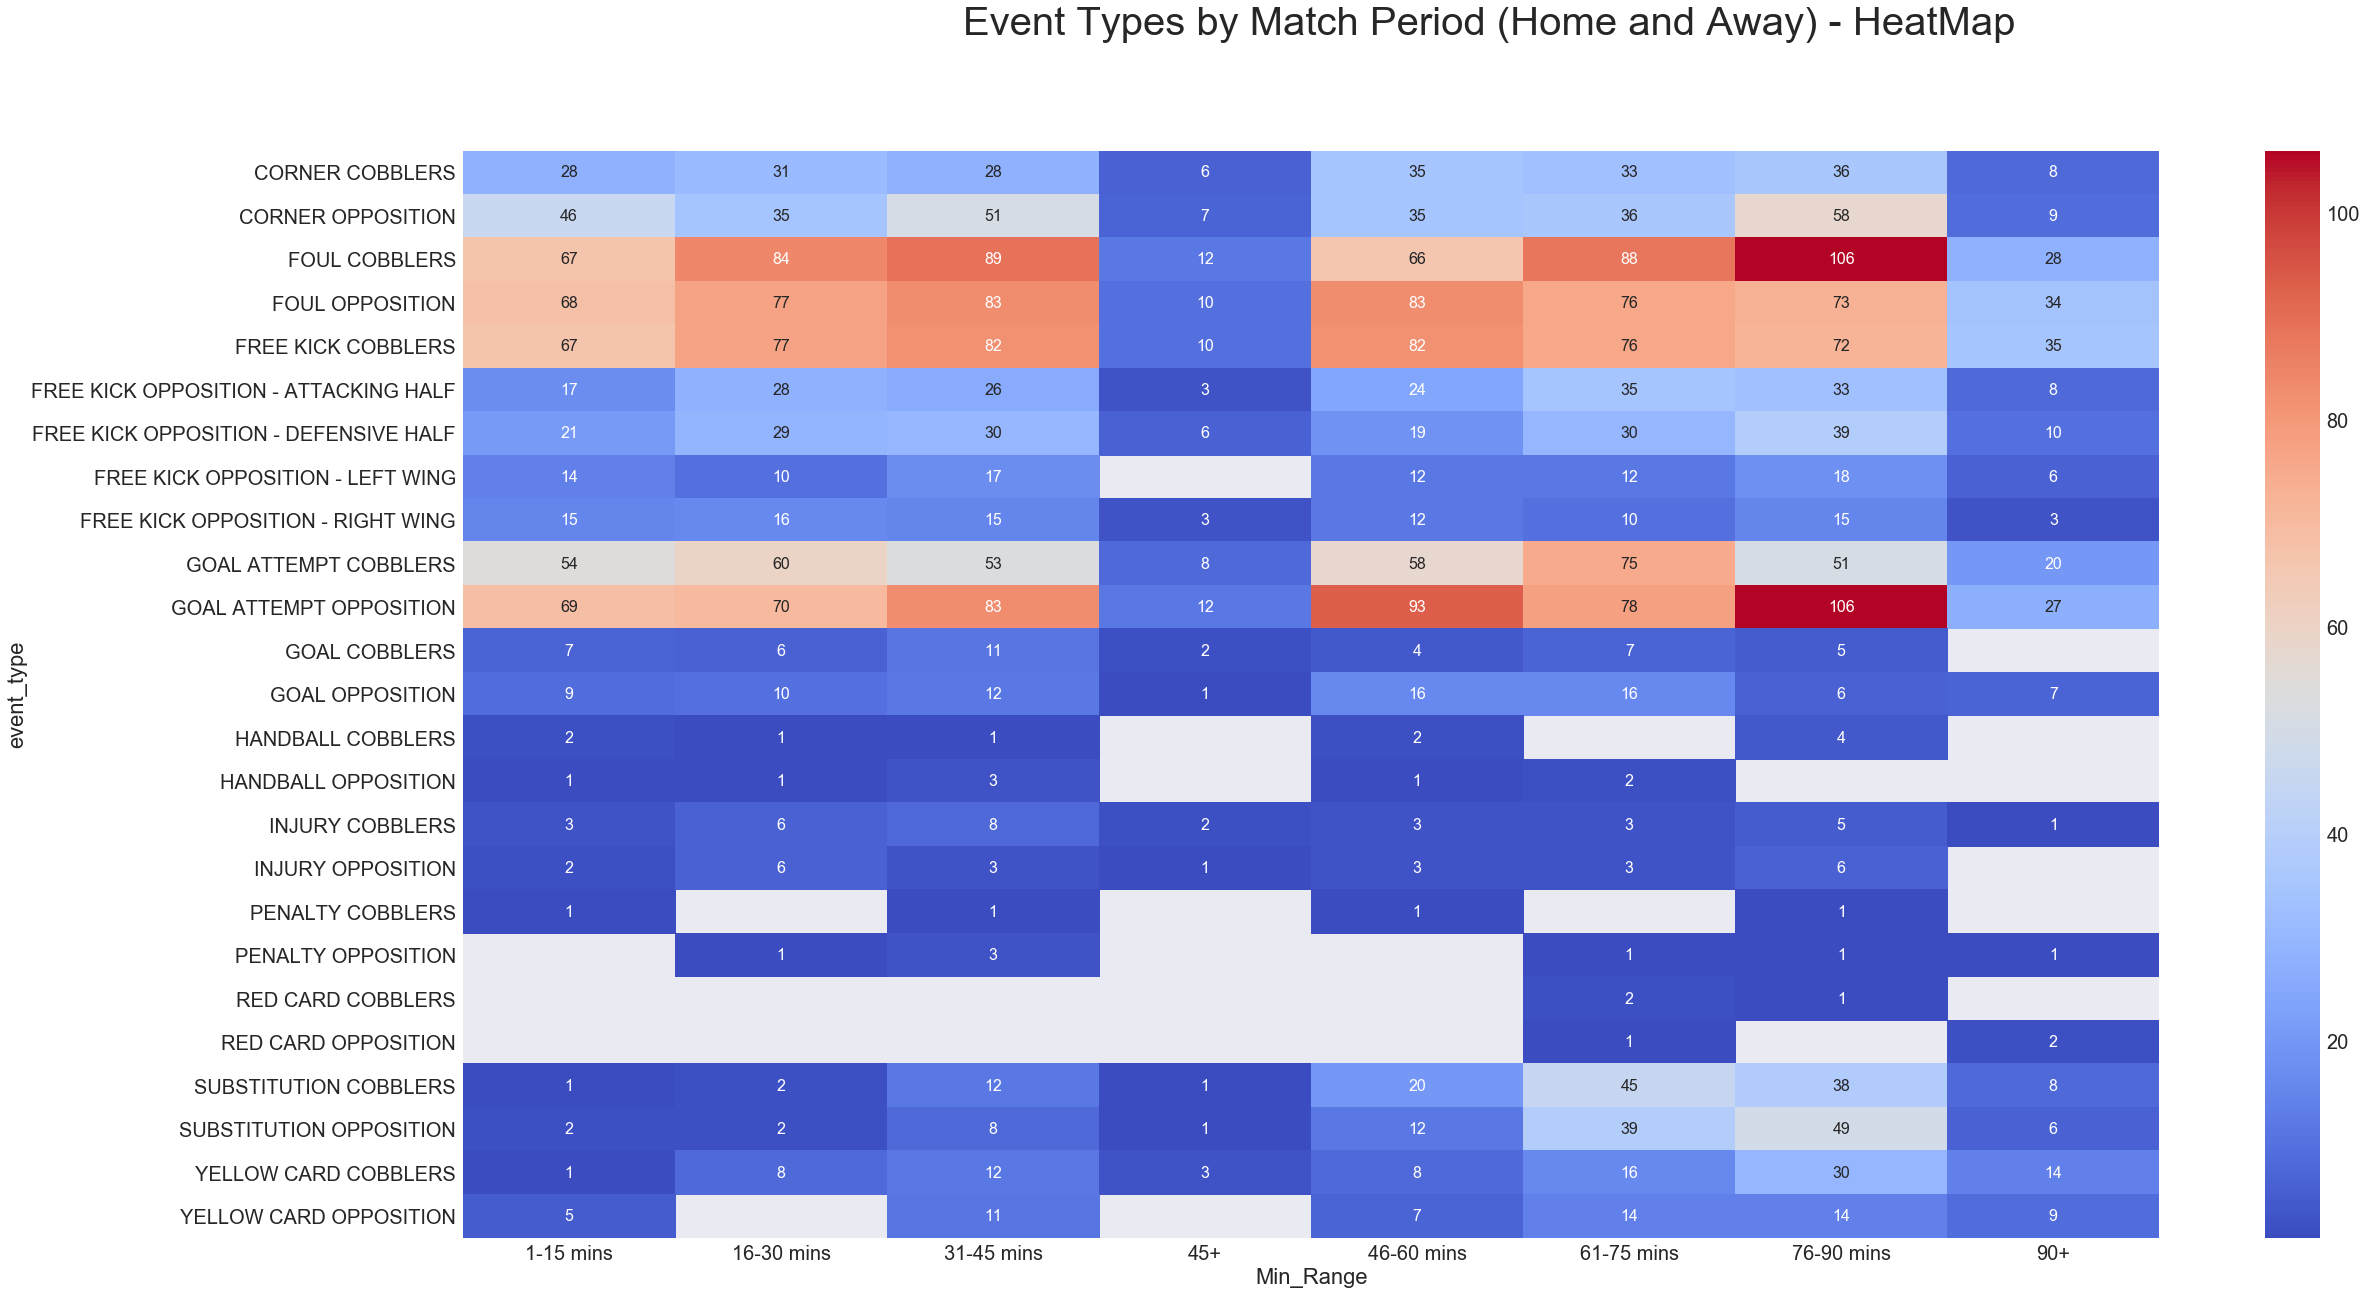

In [48]:
# get all data rows from m_data, where timing is between 0 and 90 mins (ie. not added on time)
# pivot_m2all = m_data[(m_data['added_time']==0)]
pivot_m_all = m_data[["event_type","Min_Range"]]
pivot_evts2_all = pd.DataFrame(pd.pivot_table(pivot_m_all,index=["event_type"],columns="Min_Range",aggfunc=len))
pivot_evts2_all
from matplotlib.pyplot import suptitle
fig = plt.figure(figsize=(38,20))
sns.set(font_scale = 2)
sns.heatmap(pivot_evts2_all, annot=True, cmap="coolwarm", annot_kws={'size':16}, fmt='g')
suptitle("Event Types by Match Period (Home and Away) - HeatMap", size=40)
plt.show()
fig.savefig('heatmap_homeaway_2.png')

### Analysis

- Insight 1 :
Goal attempts by the opposition happen most frequently in the 76th - 90th minutes of a game, ie. the latter stages of a game.

- Insight 2 :
Goal attempts by the opposition, also happen frequently (compared to other periods of the game), either side of half time (ie. 31st to 45th minute, and 46th to 60th minute).

- Insight 3 :
Most number of goals conceeded between 46th and 75th minute.
